<a href="https://colab.research.google.com/github/Junten/context-graph/blob/master/src/Polynomial%20Equation/AlternusVera_PolynomialEquation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reading the Data

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from string import punctuation
from scipy import sparse

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### [Google News corpus word2vec](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)

### Spell Check 

-  You can download the pre-trained model [**here**](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

- Or clone it from GitHub [**GoogleNews-vectors-negative300**](https://github.com/mmihaltz/word2vec-GoogleNews-vectors)

> It’s 1.5GB! It includes word vectors for a vocabulary of 3 million words and phrases that they trained on roughly 100 billion words from a Google News dataset. The vector length is 300 features.

**3 million words * 300 features * 4bytes/feature = ~3.35GB**

> This file consist of the word2vec -  pre-trained Google News corpus (3 billion running words) to word vector model (3 million 300-dimension English word vectors).

> Look at the [**vocabulory list**](https://github.com/chrisjmccormick/inspect_word2vec/tree/master/vocabulary) used to train this model. Each text file contains 100,000 entries from the model. 


>  There are few things that this dataset contains and not. It has stop words like  “the”, “also”, “should” and does not have stop words like “a”, “and”, “of”. As I have removed the stop words the complexity is reduced as there is no need to check the spelling for stop words. 

> It does have numbers but in the form of entried wiht #. e.g., you won’t find “100”. But it does include entries like “###MHz_DDR2_SDRAM”. 

The model used [**WinPython-64bit-2.7.10.3**](https://winpython.github.io/) for efficient python distribution on Windows system. Helps to run the scripts in batches. 

In [0]:
import pickle
import os.path
from os import path

word2vec_pickle_file = "/content/drive/My Drive/junteng_dev/data_set/words2vec.pkl"

WORDS = None
if path.exists(word2vec_pickle_file):
    with open(word2vec_pickle_file, 'rb') as f:
        WORDS = pickle.load(f)
else:
    google_word2vec_file = '/content/drive/My Drive/context_graph/GoogleNews-vectors-negative300.bin.gz'
    model = gensim.models.KeyedVectors.load_word2vec_format(google_word2vec_file, binary=True)
    words = model.index2word
    w_rank = {}
    for i,word in enumerate(words):
        w_rank[word] = i

    WORDS = w_rank

## Data Cleaning and Text Preprocessing 

*Steps included in the preprocessing:*
- Remove Special Characters and Punctuations
- Lower case the news
- Tokenization
- Remove Stop Words
- Lemmatization
- Stemming 
- Spell Check 

In [0]:
import re
from collections import Counter

def cleaning(raw_news):
    import nltk
    
    # 1. Remove non-letters/Special Characters and Punctuations
    news = re.sub("[^a-zA-Z]", " ", raw_news)
    
    # 2. Convert to lower case.
    news =  news.lower()
    
    # 3. Tokenize.
    news_words = nltk.word_tokenize( news)
    
    # 4. Convert the stopwords list to "set" data type.
    stops = set(nltk.corpus.stopwords.words("english"))
    
    # 5. Remove stop words. 
    words = [w for w in  news_words  if not w in stops]
    
    # 6. Lemmentize 
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    
    # 7. Stemming
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    
    # 8. Join the stemmed words back into one string separated by space, and return the result.
    return " ".join(stems)

def words(text): 
    return re.findall(r'\w+', text.lower())

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return - WORDS.get(word, 0)

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def spell_checker(text):
    all_words = re.findall(r'\w+', text.lower()) # split sentence to words
    spell_checked_text  = []
    for i in range(len(all_words)):
        spell_checked_text.append(correction(all_words[i]))
    return ' '.join(spell_checked_text)

###  Putting It All Together 

To make the code reusable, we need to create a function that can be called many times.

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"

train_processed_file = dataset_path + "/train_processed.csv"
test_processed_file = dataset_path + "/test_processed.csv"
valid_processed_file = dataset_path + "/valid_processed.csv"
colnames = ['jsonid', 'label', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

if path.exists(train_processed_file):
    train_news = pd.read_csv(train_processed_file, error_bad_lines=False)
else:
    train_filename =  dataset_path + "/train.tsv"
    train_news = pd.read_csv(train_filename, sep='\t', names = colnames, error_bad_lines=False)
    train_news['clean'] = train_news["headline_text"].apply(cleaning) 
    train_news['clean'] = train_news['clean'].apply(spell_checker)
    train_news.to_csv(train_processed_file, sep=',')

if path.exists(test_processed_file):
    test_news = pd.read_csv(test_processed_file, error_bad_lines=False)
else:
    test_filename =  dataset_path + "/test.tsv"
    test_news = pd.read_csv(test_filename, sep='\t', names = colnames, error_bad_lines=False)
    test_news['clean'] = test_news["headline_text"].apply(cleaning)
    test_news['clean'] = test_news['clean'].apply(spell_checker)
    test_news.to_csv(test_processed_file, sep=',')

if path.exists(valid_processed_file):
    valid_news = pd.read_csv(valid_processed_file, error_bad_lines=False)
else:
    valid_filename = dataset_path + "/valid.tsv"
    valid_news = pd.read_csv(valid_filename, sep='\t', names = colnames, error_bad_lines=False)
    valid_news['clean'] = valid_news["headline_text"].apply(cleaning)
    valid_news['clean'] = valid_news['clean'].apply(spell_checker)
    valid_news.to_csv(test_processed_file, sep=',')



#1: Sentiment analysis 

#### Using Vader Sentiment Analyser

##### [Sentiment Intensity Analyzer](http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html)


> VADER, or the **Valence Aware Dictionary and sEntiment Reasoner** has created a package that performes sentiment analysis using the polarity-based, where pieces of texts are classified as either positive or negative, or valence-based, where the intensity of the sentiment is taken into account. For example, the words ‘good’ and ‘excellent’ would be treated the same in a polarity-based approach, whereas ‘excellent’ would be treated as more positive than ‘good’ in a valence-based approach

- It is based on lexicons of sentiment-related word.
- The first three, positive, neutral and negative, represent the proportion of the text that falls into those categories.
- The final metric, the compound score, is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1

In [0]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
import warnings
import nltk.sentiment
warnings.filterwarnings('ignore')

senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

def print_sentiment_scores(sentence):
    snt = senti.polarity_scores(sentence)
    print("{:-<40} \n{}".format(sentence, str(snt)))

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
def get_vader_polarity(snt):
    if not snt:
        return None
    elif snt['neg'] > snt['pos'] and snt['neg'] > snt['neu']:
        return -1
    elif snt['pos'] > snt['neg'] and snt['pos'] > snt['neu']:
        return 1
    else:
        return 0

In [0]:
#Function to determine if a text is negative(-1) or postive (1) or neutral (0)
def get_polarity_type(sentence):
    sentimentVector = []
    snt = senti.polarity_scores(sentence)
    sentimentVector.append(get_vader_polarity(snt))
    sentimentVector.append(snt['neg'])
    sentimentVector.append(snt['neu'])
    sentimentVector.append(snt['pos'])
    sentimentVector.append(snt['compound'])
    
    print(sentimentVector)
    return sentimentVector

- senti.polarity_scores is a dictionary
- pos and neg indicates - positive and negative emotions in sentence
- we should be interested in compound score which calculates the final effect

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
train_sentiment_file = dataset_path + "/train_sentiment.csv"
test_sentiment_file = dataset_path + "/test_sentiment.csv"
valid_sentiment_file = dataset_path + "/valid_sentiment.csv"

# sentiment for train data
if path.exists(train_sentiment_file):
    train_news = pd.read_csv(train_sentiment_file, error_bad_lines=False)
else:
    sentiment = []
    vader_pol = []
    cmp_score = []
    for row in train_news['clean']:
        get_pols = get_polarity_type(row)
        sentiment.append(get_pols[1:])
        vader_pol.append(get_pols[0])
        cmp_score.append(get_pols[1:][-1]) #last element 
    train_news['sentiment_vector'] = sentiment
    train_news['vader_polarity'] = vader_pol
    train_news['sentiment_score'] = cmp_score
    train_news.to_csv(valid_sentiment_file, sep=',')

# sentiment for test data
if path.exists(test_sentiment_file):
    test_news = pd.read_csv(test_sentiment_file, error_bad_lines=False)
else:
    sentiment = []
    vader_pol = []
    cmp_score = []
    for row in test_news['clean']:
        get_pols = get_polarity_type(row)
        sentiment.append(get_pols[1:])
        vader_pol.append(get_pols[0])
        cmp_score.append(get_pols[1:][-1]) #last element 
    test_news['sentiment_vector'] = sentiment
    test_news['vader_polarity'] = vader_pol
    test_news['sentiment_score'] = cmp_score
    test_news.to_csv(test_sentiment_file, sep=',')

# sentiment for valid data
if path.exists(valid_sentiment_file):
    valid_news = pd.read_csv(valid_sentiment_file, error_bad_lines=False)
else:
    sentiment = []
    vader_pol = []
    cmp_score = []
    for row in valid_news['clean']:
        get_pols = get_polarity_type(row)
        sentiment.append(get_pols[1:])
        vader_pol.append(get_pols[0])
        cmp_score.append(get_pols[1:][-1]) #last element 
    valid_news['sentiment_vector'] = sentiment
    valid_news['vader_polarity'] = vader_pol
    valid_news['sentiment_score'] = cmp_score
    valid_news.to_csv(valid_sentiment_file, sep=',')

In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalysis():
    def __init__(self):        
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        train_sentiment_file = dataset_path + "/train_sentiment.csv"
        test_sentiment_file = dataset_path + "/test_sentiment.csv"
        valid_sentiment_file = dataset_path + "/valid_sentiment.csv"
        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]
        dataTrain = pd.read_csv(train_sentiment_file, sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv(test_sentiment_file, sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['vader_polarity'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['vader_polarity'], predicted_LogR)
        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return float(predicedProb)

In [0]:
import pickle

def DATAMINERS_getSentimentAnalysisScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    with open('/content/drive/My Drive/junteng_dev/data_set/sentiment_analysis.pkl', 'rb') as f:
        sa = pickle.load(f)
    probValue = sa.predict(text)
    return probValue

DATAMINERS_getSentimentAnalysisScore("Says the Annies List political group supports third-trimester abortions on demand.")

0.9448046694778502

#2:  LDA Topic Modelling 


In [0]:
train_news['index'] = train_news.index
data = train_news
train_lda = data[['clean', 'index']]

In [0]:
test_news['index'] = test_news.index
data = test_news
test_lda = data[['clean', 'index']]

In [0]:
valid_news['index'] = valid_news.index
data = valid_news
valid_lda = data[['clean', 'index']]

#### Split the clean news into list of words

In [0]:
processed_docs = train_lda['clean'].map(lambda doc: doc.split(" "))

### Latent Dirichlet Allocation (LDA)

> It is an example of a probabilistic topic model. Topic models are a great way to automatically explore and structure a large set of documents: they group or cluster documents based on the words that occur in them. As documents on similar topics tend to use a similar sub-vocabulary, the resulting clusters of documents can be interpreted as discussing different 'topics'.

In [0]:
def get_word_tokens(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) > 3:
            result.append(token)
    return result
tokenized_docs_local = train_news['clean'].map(get_word_tokens)

### Create a function to build the dictionary and tokenized docs for given feature

Below function does the following
* #### Dictionary
Returns Dictionary given, dataframe and column name
* #### Tokenizeddocs
Returns Tokenizeddocs, of the all the words in a text in that column can be used for bow_corpus
* #### Dictionary is filtered using Gensim filter_extremes
    Filter out tokens that appear in less than 15 documents (absolute number) or more than 0.5 documents (fraction of total corpus size, not absolute number). after the above two steps, keep only the first 100000 most frequent tokens.


In [0]:
def get_dictionary_print_words(dataframe,colname):
    dictionary_gensim = gensim.corpora.Dictionary(processed_docs)
    count = 0
    print('######## DICTIONARY Words and occurences ########')
    for k, v in dictionary_gensim.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break
    dictionary_gensim.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    return dictionary_gensim, tokenized_docs_local

#### Gensim filter_extremes

> Filter out tokens that appear less than 15 documents (absolute number) or more than 0.5 documents (fraction of total corpus size, not absolute number). after the above two steps, keep only the first 100000 most frequent tokens.

#### Create a function to build bow_corpus from dictionary and tokenized_docs

In [0]:
def get_bow_corpus_print_sample(dataframe,colname):
    dictionary_gensim, tokenized_docs_local = get_dictionary_print_words(dataframe, colname)
    bow_corpus_local = [dictionary_gensim.doc2bow(doc) for doc in tokenized_docs_local]
    bow_doc_local_0 = bow_corpus_local[0]
    print('\n ######## BOW VECTOR FIRST ITEM ########')
    print(bow_doc_local_0)
    print('\n ######## PREVIEW BOW ########')
    for i in range(len(bow_doc_local_0)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_local_0[i][0], 
                                               dictionary_gensim[bow_doc_local_0[i][0]], bow_doc_local_0[i][1]))
    return bow_corpus_local, dictionary_gensim

**Gensim doc2bow**

For each document we create a dictionary reporting how many words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier

#### Create a function to build tfidf_corpus from bow_corpus

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [0]:
def get_tfidf_corpus_print_sample(bow_corpus_local):
    from gensim import corpora, models
    tfidf = models.TfidfModel(bow_corpus_local)
    tfidf_corpus_local = tfidf[bow_corpus_local]
    print('\n ######## TFIDF VECTOR FIRST ITEM ########')
    
    from pprint import pprint
    for doc in tfidf_corpus_local:
        pprint(doc)
        break
    return tfidf_corpus_local

#### Create a function to run ldamodel and print top 10 topics

In [0]:
def get_lda_model_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model

#### Create a function to run ldamodel and print top 10 topics

In [0]:
def get_lda_model_topics_topwords_print_top_topics(bow_corpusforlda,numtopics,dictionaryforlda):
    lda_model = gensim.models.LdaMulticore(bow_corpusforlda, num_topics=numtopics, id2word=dictionaryforlda, passes=2, workers=2, random_state=1)
    lda_all_topics=lda_model.show_topics(num_topics=numtopics, num_words=10,formatted=False)
    lda_topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in lda_all_topics]

    #Below Code Prints Topics and Words
    for topic,words in lda_topics_words:
        print(str(topic)+ "::"+ str(words))
    return lda_model,lda_topics_words

#### Create a function to enrich data with lda topics, lda topics score, top words

In [0]:
def identify_topic_number_score_label_topwords(text,dictionary_local,lda_model_local,lda_topics_top_words_local):
    bow_vector_local = dictionary_local.doc2bow(get_word_tokens(text))
    topic_number_local, topic_score_local = sorted(
        lda_model_local[bow_vector_local], key=lambda tup: -1*tup[1])[0]
    #print (topic_number_local, topic_score_local)
    return pd.Series([topic_number_local, topic_score_local," ".join(lda_topics_top_words_local[int(topic_number_local)][1])])

#### Create a function that can enrich topic data to dataframe

In [0]:
def update_lda_results_to_dataset(dataframe,topiccolnames,coltoapplylda,colnamedictionary,colnameldamodel, colnameldatopwords):
    dataframe[topiccolnames] = dataframe.apply(
    lambda row: identify_topic_number_score_label_topwords(
        row[coltoapplylda],colnamedictionary,colnameldamodel,
        colnameldatopwords), axis=1)
    return dataframe

### Bag of Words

#### Create a dictionary and tokens

> Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

#### Create a function to convert text to word tokens from cleaned dataset

In [0]:
bow_corpus_headline, dictionary_headline = get_bow_corpus_print_sample(train_news,
                                                                      'clean')

######## DICTIONARY Words and occurences ########
0 abort
1 anni
2 demand
3 group
4 list
5 polit
6 say
7 support
8 third
9 trimmest
10 administr

 ######## BOW VECTOR FIRST ITEM ########
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (6, 1), (7, 1)]

 ######## PREVIEW BOW ########
Word 0 ("abort") appears 1 time.
Word 1 ("demand") appears 1 time.
Word 2 ("group") appears 1 time.
Word 3 ("list") appears 1 time.
Word 4 ("polit") appears 1 time.
Word 6 ("support") appears 1 time.
Word 7 ("third") appears 1 time.


### Running LDA using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

In [0]:
lda_model_headline, lda_headline_topic_words = get_lda_model_topics_topwords_print_top_topics(
    bow_corpus_headline, 10 ,dictionary_headline)

0::['vote', 'sent', 'republican', 'support', 'state', 'democrat', 'obama', 'romney', 'percent', 'would']
1::['percent', 'state', 'time', 'averag', 'american', 'school', 'year', 'hous', 'billion', 'rais']
2::['presid', 'obama', 'country', 'bill', 'barack', 'state', 'bush', 'year', 'billion', 'florida']
3::['year', 'percent', 'school', 'would', 'budget', 'public', 'every', 'state', 'obama', 'spend']
4::['obama', 'state', 'nation', 'said', 'million', 'peopl', 'work', 'presid', 'clinton', 'text']
5::['percent', 'year', 'million', 'state', 'obama', 'time', 'rate', 'peopl', 'presid', 'wisconsin']
6::['percent', 'increas', 'american', 'peopl', 'state', 'year', 'health', 'sinc', 'care', 'vote']
7::['year', 'last', 'state', 'million', 'health', 'vote', 'creat', 'number', 'nation', 'would']
8::['health', 'care', 'state', 'year', 'cost', 'would', 'percent', 'plan', 'insur', 'budget']
9::['state', 'trump', 'unit', 'donald', 'georgia', 'want', 'clinton', 'percent', 'feder', 'iller']


#### Generate TF-IDF bow_corpus
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [0]:
tfidf_corpus_headline = get_tfidf_corpus_print_sample(bow_corpus_headline)


 ######## TFIDF VECTOR FIRST ITEM ########
[(0, 0.3213684467163471),
 (1, 0.45885933393208955),
 (2, 0.3867148870952622),
 (3, 0.4388676762258462),
 (4, 0.3854712129906647),
 (6, 0.25709294587835624),
 (7, 0.3596280760961804)]


### Running LDA model using Bag of Words
Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’

**GOAL**: To get top ten topics with top words. 

In [0]:
lda_tfidf_model_headline  = get_lda_model_print_top_topics(tfidf_corpus_headline,10,dictionary_headline)

0::['care', 'health', 'american', 'percent', 'year', 'nation', 'rate', 'support', 'hous', 'million']
1::['year', 'percent', 'state', 'busi', 'feder', 'million', 'near', 'scott', 'budget', 'bush']
2::['percent', 'obama', 'rate', 'year', 'sinc', 'presid', 'abort', 'unemploy', 'state', 'first']
3::['vote', 'court', 'state', 'social', 'secur', 'said', 'time', 'trump', 'peopl', 'year']
4::['state', 'percent', 'nation', 'year', 'highest', 'country', 'today', 'vote', 'cost', 'billion']
5::['immigra', 'iller', 'year', 'percent', 'state', 'obamacare', 'american', 'school', 'vote', 'million']
6::['would', 'obama', 'presid', 'mccain', 'trump', 'plan', 'iraq', 'barack', 'year', 'money']
7::['state', 'billion', 'presid', 'obama', 'iran', 'person', 'medical', 'year', 'bill', 'democrat']
8::['state', 'rais', 'child', 'obama', 'year', 'vote', 'bill', 'every', 'first', 'wisconsin']
9::['state', 'year', 'vote', 'percent', 'peopl', 'make', 'clinton', 'hillary', 'time', 'campaign']


#### Explanation for LDA 
![[Explanation of LDA](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508239587/n4ZpIXl_egq7mq.png)](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1508239587/n4ZpIXl_egq7mq.png)

### Semisupervised Labeling
Based on train,test and valid data explored the topic scores for sample data and identified below topics

In [0]:
semisupervised_topic_labels = ['topic0','topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8','topic9']

####  Function to add topicnumber, topicscore, topiclabel, topwords

In [0]:
headlinetopiccolnames = ['topic_number','lda_score','topic_top_words']
train_news = update_lda_results_to_dataset(
    train_news, headlinetopiccolnames,'clean', dictionary_headline, lda_model_headline, lda_headline_topic_words)

In [0]:
test_news = update_lda_results_to_dataset(
    test_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)

In [0]:
valid_news = update_lda_results_to_dataset(
    valid_news,headlinetopiccolnames,'clean',
  dictionary_headline,lda_model_headline,lda_headline_topic_words)

### Visualize the LDA Distribution of news against Top 10 Topics

**GOAL 1:** *Each of the N documents will be represented in the LDA model by a vector of length M*
**GOAL 2:** *Each of the M topics is represented by a vector of length V*

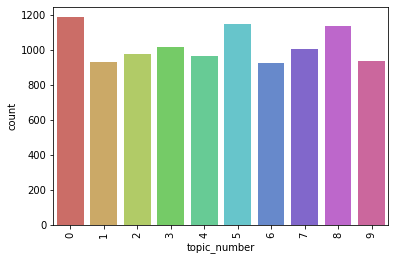

In [0]:
import seaborn as sb
def create_distribution(dataFile):
    g = sb.countplot(x='topic_number', data=dataFile, palette='hls')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)

    return g

create_distribution(train_news) # TRAIN Document Vector

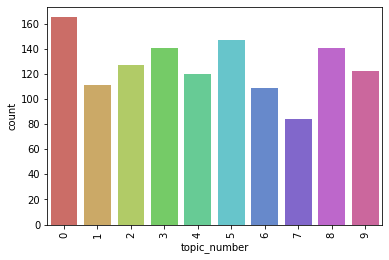

In [0]:
create_distribution(test_news)# TEST Document Vector

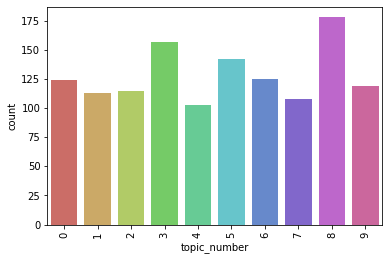

In [0]:
create_distribution(valid_news)# VALID Document Vector

##### Saved the latest dataset into a seperate CSV file 

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
train_lda_file = dataset_path + "/train_lda.csv"
test_lda_file = dataset_path + "/test_lda.csv"
valid_lda_file = dataset_path + "/valid_lda.csv"

if not path.exists(train_lda_file):
    train_news.to_csv(train_lda_file, sep=',')
if not path.exists(test_lda_file):
    test_news.to_csv(test_lda_file, sep=',')
if not path.exists(valid_lda_file):
    valid_news.to_csv(valid_lda_file, sep=',')

In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class LDATopicModelling():

    def __init__(self):
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        train_lda_file = dataset_path + "/train_lda.csv"
        test_lda_file = dataset_path + "/test_lda.csv"
        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
        dataTrain = pd.read_csv(train_lda_file, sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv(test_lda_file, sep=',', header=None, names = columnNames)

        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
    
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['topic_number'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['topic_number'], predicted_LogR)
        # print("LDA Topic Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

In [0]:
import pickle

def DATAMINERS_getLDATopicModellingScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    with open('/content/drive/My Drive/junteng_dev/data_set/lda_topic_modelling.pkl','rb') as f:
        ldaTopicModelling = pickle.load(f)
    binaryValue, probValue = ldaTopicModelling.predict(text)
    return float(probValue)

DATAMINERS_getLDATopicModellingScore("Says the Annies List political group supports third-trimester abortions on demand.")

0.08185803576455541

#3:  Sensational Feature Analysis

#### [Sensational Words Corpus](https://www.thepersuasionrevolution.com/380-high-emotion-persuasive-words/)

>  Words aren’t just strings of alphabets sewn together with ink. Words are cues. Words are triggers. Words when used correctly can transform an “eh whatever” into “wow that’s it!”. Words can make you go from literally ROFL to fuming with fury to an uncontrollable-urge-to-take-action-NOW-or-the-earth-may-stop-swinging -on-its-axis.

> Highly emotional words are capable capable of transforming an absolute no into almost yes and a “perhaps” into “for sure”!

Words that are used:
- When you are trying to sell people a solution
- When you are trying to get them to take an action (like, share, subscribe, buy)
- When you are trying to get people to click and read your article
- When you are trying to get someone to agree with you

**There are 1400+ words that are both positive and negative emotions that will help to predict the sensational score for an article**

> I have used these words to perform cosin similarity and predict the sensational similarity score for each news in the give dataset.

In [0]:
columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score", "index", "topic_number", "lda_score", "topic_top_words"]
dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
dataTrain = pd.read_csv(dataset_path  + '/train_lda.csv', sep=',', header=None, names = columnNames)
dataTest = pd.read_csv(dataset_path  + '/test_lda.csv', sep=',', header=None, names = columnNames)

#dropping columns
columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector', 'sentiment_vector','vader_polarity', 'sentiment_score', 'index', 'topic_number', 'lda_score', 'topic_top_words']
train_news = dataTrain.drop(columns=columnsToRemove)
test_news = dataTest.drop(columns=columnsToRemove)
train_news = train_news.loc[1:] 
test_news = test_news.loc[1:]

In [0]:
corpus = []
for i in train_news['clean']:
    corpus.append(i)
# corpus

sensational_corpus=[]
sensational_words = pd.read_csv("/content/drive/My Drive/junteng_dev/data_set/sensational_words_dict.csv", sep="\t+", header=None, usecols=[0] )
print(len(sensational_words))
sensational_dictionary = ' '.join(sensational_words[0].astype(str))
sensational_corpus.append(sensational_dictionary)

1443


## SenticNet:   

#### Data Enrichment 

> It provides polarity associated with 50,000 natural language concepts. A polarity is a floating number between -1 and +1. Minus one is extreme negativity, and plus one is extreme positivity. The knowledge base is free. It can be downloaded as XML file. 
SenticNet 5 reaches 100,000 commonsense concepts by employing recurrent neural networks to infer primitives by lexical substitution.

In [0]:
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings("ignore")
sentic_net = pd.read_csv("/content/drive/My Drive/junteng_dev/data_set/senticnet5.txt", sep="\t+", header=None, usecols=[0,1,2], names = ["Token", "Polarity", "Intensity"])
sentic_net = sentic_net[~sentic_net['Token'].str.contains('|'.join('_'),na=False)]
sentic_net = sentic_net.reset_index(drop=True)
print("Senticnet Vocab Size: ",len(sentic_net))

Senticnet Vocab Size:  39891


In [0]:
# sentic_net['Token'] provides list of words from the SenticNet DICTIONARY
senti_pos = sentic_net.loc[sentic_net.Polarity == "positive"]
senti_pos = senti_pos.loc[senti_pos.Intensity > 0.90]
dictionary = ' '.join(senti_pos.Token.astype(str))
sensational_corpus.append(dictionary)
print(len(senti_pos))

2040


## TF-IDF and Cosine Similarity

#### TF-IDF

> TF-IDF (Term Frequency - Inverse Document Frequency) can be represented tf(d,t) X idf(t). TF-IDF uses the method diminishing the weight (importance) of words appeared in many documents in common, considered them incapable of discerning the documents, rather than simply counting the frequency of words as CountVectorizer does. The outcome matrix consists of each document (row) and each word (column) and the importance (weight) computed by tf * idf (values of the matrix)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer(max_features=1000)

tfidf_corpus = tfidfVec.fit_transform(corpus)
tf_idf_senti = tfidfVec.fit_transform(sensational_corpus)
words = tfidfVec.get_feature_names()

In [0]:
tfidf_corpus.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
tf_idf_senti.toarray()

array([[0.02934579, 0.05869158, 0.05869158, ..., 0.        , 0.        ,
        0.08803737],
       [0.        , 0.        , 0.        , ..., 0.19269152, 0.06423051,
        0.        ]])

In [0]:
tfidfVec.vocabulary_

{'absolutely': 1,
 'advantage': 3,
 'qaeda': 742,
 'amazing': 4,
 'antagonistic': 6,
 'attack': 14,
 'authentic': 15,
 'authority': 16,
 'banned': 21,
 'behind': 24,
 'the': 929,
 'scenes': 881,
 'best': 26,
 'bill': 28,
 'bitterness': 29,
 'black': 31,
 'market': 187,
 'blacklisted': 32,
 'blissful': 34,
 'up': 990,
 'breathtaking': 37,
 'campaign': 40,
 'for': 95,
 'censored': 42,
 'cheer': 44,
 'cheerful': 45,
 'church': 47,
 'class': 48,
 'concealed': 52,
 'confessions': 53,
 'confidential': 55,
 'control': 59,
 'controversial': 61,
 'cost': 62,
 'cover': 63,
 'crime': 64,
 'critical': 65,
 'infrastructure': 126,
 'cyber': 67,
 'security': 886,
 'terror': 928,
 'daring': 68,
 'of': 388,
 'desire': 71,
 'disastrous': 72,
 'drug': 76,
 'ecstatic': 79,
 'on': 409,
 'emergency': 81,
 'response': 859,
 'enforcement': 83,
 'eye': 85,
 'opening': 415,
 'faith': 86,
 'faithfulness': 87,
 'fbi': 89,
 'first': 93,
 'responder': 858,
 'high': 118,
 'forbidden': 96,
 'force': 97,
 'fire': 92,


In [0]:
train_tfidf = tfidfVec.fit_transform(train_news['clean'])
print('Training dim:', train_tfidf.shape)
print(train_tfidf.A[:10])


test_tfidf = tfidfVec.fit_transform(test_news['clean'])
print('Test dim:', test_tfidf.shape)
print(test_tfidf.A[:10])


valid_tfidf = tfidfVec.fit_transform(valid_news['clean'])
print('Valid dim:', valid_tfidf.shape)
print(valid_tfidf.A[:10])

Training dim: (10239, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Test dim: (1266, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Valid dim: (1284, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]



#### Cosine Similarity Score

> The cosine similarity between two vectors (or two documents on the Vector Space) is a measure that calculates the cosine of the angle between them. This metric is a measurement of orientation and not magnitude, it can be seen as a comparison between documents on a normalized space because we’re not taking into the consideration only the magnitude of each word count (tf-idf) of each document, but the angle between the documents.

> I have compared the sentiment vector of each doucment and estimated a similarity score which is saved as a column in the training and test dataset. 

In [0]:
# from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial
similarity_score = []
for i in range(len(train_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))

In [0]:
train_news['sensational_score'] = similarity_score
train_news.head(5)

,,headline_text,clean,sensational_score
1.0,1,When did the decline of coal start? It started...,decline coal start start natur gas took start ...,0.061786
2.0,2,"Hillary Clinton agrees with John McCain ""by vo...",hillary clinton agre john mccain vote give geo...,0.059743
3.0,3,Health care reform legislation is likely to ma...,health care reform legis like mandat free sex ...,0.052559
4.0,4,The economic turnaround started at the end of ...,econom turnaround start end term,0.066800
5.0,5,The Chicago Bears have had more starting quart...,chicago bear start quarterback last year total...,0.048691


In [0]:
corpus = []
for i in test_news['clean']:
    corpus.append(i)
# corpus

tfidf_corpus = tfidfVec.fit_transform(corpus)

similarity_score = []
for i in range(len(test_tfidf.toarray())):
    similarity_score.append(1 - spatial.distance.cosine(tf_idf_senti[0].toarray(), tfidf_corpus[i].toarray()))
    
test_news['sensational_score'] = similarity_score
test_news.head(5)

,,headline_text,clean,sensational_score
1.0,1,Wisconsin is on pace to double the number of l...,wisconsin pace doubl number layoff year,0.019047
2.0,2,Says John McCain has done nothing to help the ...,say john mccain done noth help vet,0.026551
3.0,3,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici support plan cut choice medic...,0.061022
4.0,4,When asked by a reporter whether hes at the ce...,ask report whether he center crimini scheme vi...,0.065230
5.0,5,Over the past five years the federal governmen...,past five year feder govern paid million retir...,0.066946


##### Saved the latest dataset into a seperate CSV file 

In [0]:
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
train_sensationalism_file = dataset_path + "/train_sensationalism.csv"
test_sensationalism_file = dataset_path + "/test_sensationalism.csv"
valid_sensationalism_file = dataset_path + "/valid_sensationalism.csv"
train_news.to_csv(train_sensationalism_file, sep=',')
test_news.to_csv(train_sensationalism_file, sep=',')
valid_news.to_csv(valid_sensationalism_file, sep=',')

   


In [0]:
import numpy as np
columnNames = ["jsonid", "headline_text", "clean", "sensational_score"]

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
train_sensationalism_file = dataset_path + "/train_sensationalism.csv"
test_sensationalism_file = dataset_path + "/test_sensationalism.csv"
dataTrain = pd.read_csv(train_sensationalism_file, sep=',', header=None, names = columnNames)
dataTest = pd.read_csv(test_sensationalism_file, sep=',', header=None, names = columnNames)

dataTrain = dataTrain.loc[1:]
dataTest = dataTest.loc[1:]

dataTrain.head(5)

,jsonid,headline_text,clean,sensational_score
1.0,1.0,Wisconsin is on pace to double the number of l...,wisconsin pace doubl number layoff year,0.019046839606136512
2.0,2.0,Says John McCain has done nothing to help the ...,say john mccain done noth help vet,0.026551492373704022
3.0,3.0,Suzanne Bonamici supports a plan that will cut...,suzanne bonamici support plan cut choice medic...,0.061021958191452175
4.0,4.0,When asked by a reporter whether hes at the ce...,ask report whether he center crimini scheme vi...,0.065229738576433
5.0,5.0,Over the past five years the federal governmen...,past five year feder govern paid million retir...,0.06694575545774362


In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SensationalismFeature():

    def __init__(self):        
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        train_sensationalism_file = dataset_path + "/train_sensationalism.csv"
        test_sensationalism_file = dataset_path + "/test_sensationalism.csv"
        columnNames = ["jsonid", "headline_text", "clean", "sensational_score"]
        dataTrain = pd.read_csv(train_sensationalism_file, sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv(test_sensationalism_file, sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
            
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df = 30, use_idf = True, smooth_idf = True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf', LogisticRegression(solver='liblinear', C = 32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['sensational_score'].astype(str))
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['sensational_score'].astype(str), predicted_LogR)
        print("Sensationalism Model Trained - accuracy:   %0.6f" % score)
    
    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

In [0]:
import pickle

def DATAMINERS_getSensationalismScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    with open('/content/drive/My Drive/junteng_dev/data_set/sensational.pkl','rb') as f:
        sf = pickle.load(f)
    binaryValue, probValue = sf.predict(text)
    return (float(probValue*100))

DATAMINERS_getSensationalismScore("Says the Annies List political group supports third-trimester abortions on demand.")

0.0812206937482198

#4: Political Affiliation Model 

In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from nltk.stem.porter import *
from sklearn import metrics
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import  LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import itertools

class PartyAffiliation():
    
    # API to check whether the subject(Headline) is present in the 
    # - democrats most used words if the party affiliation is democrat
    # - republicans most used words if the part affiliation is republican
    def partyAffiliationFromHeadline(self, r):
        v = r['subject_str']
        p = r['party_str']
        if (p =='democrat'):
            s2 = set(self.countDemV.get_feature_names())
        if (p =='republican'):
            s2 = set(self.countRepV.get_feature_names())
        if (p != 'democract' and p !='republican'):
            return 1 #'true'        
        if set(v).intersection(s2):
            return 1 #'true'
        else:
            return 0 #'false'

    #API to convert true, mostly-true and half-true to true
    # false, barely-true and pants-fire to false
    def convertMulticlassToBinaryclass(self, r):
        v = r['label']
        if (v == 'true'):
            return 1 #'true'
        if (v == 'mostly-true'):
            return 1 #'true'
        if (v == 'half-true'):
            return 1 #'true'
        if (v == 'barely-true'):
            return 0 #'false'
        if (v == 'false'):
            return 0 #'false'
        if (v == 'pants-fire'):
            return 0 #'false'
            
            
            
    def plot_confusion_matrix(self, cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')       
            
    
    def __init__(self):        
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        columnNamesPar = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrainPar = pd.read_csv(dataset_path + "/train.tsv", sep='\t', header=None, names = columnNamesPar)
        dataValidatePar = pd.read_csv(dataset_path + "/valid.tsv", sep='\t', header=None, names = columnNamesPar)
        dataTestPar = pd.read_csv(dataset_path + "/test.tsv", sep='\t', header=None, names = columnNamesPar)
        
    
        # Remove unwanted columns in the dataset
        columnsToRemovePar = ['id', 'speaker', 'context','speaker_job_title', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrainPar = dataTrainPar.drop(columns=columnsToRemovePar)
        dataValidatePar = dataValidatePar.drop(columns=columnsToRemovePar)
        dataTestPar = dataTestPar.drop(columns=columnsToRemovePar)
        
        # convert the labels to true and false only
        dataTrainPar['label'] = dataTrainPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataValidatePar['label'] = dataValidatePar.apply(self.convertMulticlassToBinaryclass, axis=1)
        dataTestPar['label'] = dataTestPar.apply(self.convertMulticlassToBinaryclass, axis=1)
        
        # display all the party affiliations and show the count of each party 
#         dataTrainPar.groupby('party_affiliation').count()[['state_info']].rename(
#         columns={'state_info': 'count'}).sort_values(
#         'count', ascending=False).reset_index().plot.bar(
#         x='party_affiliation', y='count', figsize=(16, 10), fontsize=18);
        
        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations
        rowsToRemove = ['Moderate', 'activist', 'business-leader', 'columnist', 'constitution-party', 'democratic-farmer-labor', 'education-official', 'government-body', 'green', 'independent', 'journalist', 'labor-leader', 'liberal-party-canada', 'libertarian', 'nan', 'newsmaker', 'ocean-state-tea-party-action', 'organization', 'state-official', 'talk-show-host', 'tea-party-member']

        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'Moderate']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'activist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'business-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'columnist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'constitution-party']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'democratic-farmer-labor']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'education-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'government-body']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'green']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'independent']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'journalist']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'labor-leader']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'liberal-party-canada']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'libertarian']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'nan']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'newsmaker']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'organization']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'state-official']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'talk-show-host']
        dataTrainPar = dataTrainPar[dataTrainPar.party_affiliation != 'tea-party-member']

        # As we are considering only democrat, republican and none (top 3 party affiliations),
        # ignoring other party affiliations

        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'Moderate']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'activist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'business-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'columnist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'constitution-party']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'democratic-farmer-labor']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'education-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'government-body']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'green']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'independent']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'journalist']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'labor-leader']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'liberal-party-canada']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'libertarian']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'nan']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'newsmaker']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'ocean-state-tea-party-action']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'organization']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'state-official']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'talk-show-host']
        dataTestPar = dataTestPar[dataTestPar.party_affiliation != 'tea-party-member']

        
        dataTrainPar['party_str'] = dataTrainPar['party_affiliation'].astype(str)
        dataTestPar['party_str'] = dataTestPar['party_affiliation'].astype(str)
        

        #predicting truth level
#        dataTrainPar.groupby('label').count()[['party_affiliation']].reset_index().plot.bar(x='label', y='party_affiliation')
        
        # get the most used democrat words
        self.countDemV = CountVectorizer(stop_words='english', min_df=40, max_df=80, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        dataTrainDem= dataTrainPar
        dataTrainDem = dataTrainPar.loc[dataTrainPar['party_str'] == 'democrat']
        dem_count = self.countDemV.fit_transform(dataTrainDem['statement'].values)
        
        #get the republican most used words
        
        self.countRepV = CountVectorizer(stop_words='english', min_df=20, max_df=40, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        dataTrainRep= dataTrainPar
        dataTrainRep = dataTrainPar.loc[dataTrainPar['party_str'] == 'republican']
        rep_count = self.countRepV.fit_transform(dataTrainRep['statement'].values)

        dataTestDem= dataTestPar
        dataTestDem = dataTestPar.loc[dataTestPar['party_str'] == 'democrat']
        
        dataTrainPar['subject_str'] = dataTrainPar['subject'].astype(str).str.split() 
        dataTrainPar['label_str'] = dataTrainPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTestPar['subject_str'] = dataTestPar['subject'].astype(str).str.split() 
        dataTestPar['label_str'] = dataTestPar.apply(self.partyAffiliationFromHeadline, axis=1)

        dataTrainDem['subject_str'] = dataTrainDem['subject'].astype(str).str.split() 
        dataTrainDem['label_str'] = dataTrainDem.apply(self.partyAffiliationFromHeadline, axis=1)
    
        dataTestDem['subject_str'] = dataTestDem['subject'].astype(str).str.split() 
        dataTestDem['label_str'] = dataTestDem.apply(self.partyAffiliationFromHeadline, axis=1)
        
        
        self.model = LogisticRegression()
        self.model = self.model.fit(dataTrainPar['label_str'].values.reshape(-1, 1), dataTrainPar['label'].values)
        predicted_LogR = self.model.predict(dataTestPar['label_str'].values.reshape(-1, 1))
        score = metrics.accuracy_score(dataTestPar['label'], predicted_LogR)
        # print("Party Affiliation Model Trained - accuracy:   %0.6f" % score)

    
    def predict(self, headline, party):
                
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['subject', 'party_str'])
        dfrme['subject_str'] = headline
        dfrme['party_str'] = party        

        dfrme['subject'] = headline
        dfrme['subject_str'] = dfrme['subject'].astype(str).str.split() 
        dfrme['label_str'] = dfrme.apply(self.partyAffiliationFromHeadline, axis=1)
        
        x = dfrme['label_str'].values.reshape(-1, 1)
        predicted = self.model.predict(x)
        predicedProb = self.model.predict_proba(x)[:,1]
        return predicted, predicedProb
                    
    
##testing code
f = PartyAffiliation()
#pf.predict("Says the Annies List political group supports third-trimester abortions on demand", "republican")

In [0]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
import pandas as pd
import numpy as np
import os

def loadJsonFiles(directory, veracity):    
    shouldAppend = False
    for filename in os.listdir(directory):
        df2 = pd.read_json(directory + filename, lines=True)
        if (shouldAppend):
            df = df.append(df2, ignore_index=True, sort=True)      
        else:
            df = df2
        df['veracity'] = veracity
        shouldAppend = True
        
            
    # removing nan values    
    df['source'].fillna("", inplace=True)
    for index, row in df.iterrows():
        if (type(row['authors']) == float):
            df.at[index, 'authors'] = []

            
    #removing unnecessary columns
    df = df.drop(columns=['keywords','meta_data','movies', 'keywords', 'summary', 'publish_date','top_img'])
    return df

def loadDataset():
    dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
    dataFake = loadJsonFiles(dataset_path + "/FakeNewsContent/", 0)
    dataReal = loadJsonFiles(dataset_path + "/RealNewsContent/", 1)
    return dataReal, dataFake

dataFake, dataReal = loadDataset()

dataTrainFake = dataFake[:100]
dataTrainReal = dataReal[:100]
dataTestFake = dataFake[101:]
dataTestReal = dataReal[101:]

dataTest = dataTestFake.append(dataTestReal,ignore_index=True, sort=True)      
dataTrain = dataTrainFake.append(dataTrainReal,ignore_index=True, sort=True)    
dataAll = dataFake.append(dataReal, ignore_index=True, sort=True)      

In [0]:
import pickle 

def DATAMINERS_getPartyAffiliationScore(headline, partyName): # return between 0 and 1, being 0 = True,  1 = Fake
    if ( (headline == "") | (partyName == "") ):
        return 0
    with open('/content/drive/My Drive/junteng_dev/data_set/party_affiliation.pkl', 'rb') as f:
        partyAffiliation = pickle.load(f)
    binaryValue, probValue = partyAffiliation.predict(headline, partyName)
    return 1 - float(probValue)

DATAMINERS_getPartyAffiliationScore("Says the Annies List political group supports third-trimester abortions on demand", "republican")

0.3956047752353582

#5: Click Bait 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Clickbait():
    
    question_words = ['who', 'whos', 'whose', 'what', 'whats', 'whatre', 'when', 'whenre', 'whens', 'couldnt',
            'where', 'wheres', 'whered', 'why', 'whys', 'can', 'cant', 'could', 'will', 'would', 'is',
            'isnt', 'should', 'shouldnt', 'you', 'your', 'youre', 'youll', 'youd', 'here', 'heres',
            'how', 'hows', 'howd', 'this', 'are', 'arent', 'which', 'does', 'doesnt']

    contractions = ['tis', 'aint', 'amnt', 'arent', 'cant', 'couldve', 'couldnt', 'couldntve',
                    'didnt', 'doesnt', 'dont', 'gonna', 'gotta', 'hadnt', 'hadntve', 'hasnt',
                    'havent', 'hed', 'hednt', 'hedve', 'hell', 'hes', 'hesnt', 'howd', 'howll',
                    'hows', 'id', 'idnt', 'idntve', 'idve', 'ill', 'im', 'ive', 'ivent', 'isnt',
                    'itd', 'itdnt', 'itdntve', 'itdve', 'itll', 'its', 'itsnt', 'mightnt',
                    'mightve', 'mustnt', 'mustntve', 'mustve', 'neednt', 'oclock', 'ol', 'oughtnt',
                    'shant', 'shed', 'shednt', 'shedntve', 'shedve', 'shell', 'shes', 'shouldve',
                    'shouldnt', 'shouldntve', 'somebodydve', 'somebodydntve', 'somebodys',
                    'someoned', 'someonednt', 'someonedntve', 'someonedve', 'someonell', 'someones',
                    'somethingd', 'somethingdnt', 'somethingdntve', 'somethingdve', 'somethingll',
                    'somethings', 'thatll', 'thats', 'thatd', 'thered', 'therednt', 'theredntve',
                    'theredve', 'therere', 'theres', 'theyd', 'theydnt', 'theydntve', 'theydve',
                    'theydvent', 'theyll', 'theyontve', 'theyre', 'theyve', 'theyvent', 'wasnt',
                    'wed', 'wedve', 'wednt', 'wedntve', 'well', 'wontve', 'were', 'weve', 'werent',
                    'whatd', 'whatll', 'whatre', 'whats', 'whatve', 'whens', 'whered', 'wheres',
                    'whereve', 'whod', 'whodve', 'wholl', 'whore', 'whos', 'whove', 'whyd', 'whyre',
                    'whys', 'wont', 'wontve', 'wouldve', 'wouldnt', 'wouldntve', 'yall', 'yalldve',
                    'yalldntve', 'yallll', 'yallont', 'yallllve', 'yallre', 'yallllvent', 'yaint',
                    'youd', 'youdve', 'youll', 'youre', 'yourent', 'youve', 'youvent']
    
    def process_text(self, text):
        result = text.replace('/', '').replace('\n', '')
        result = re.sub(r'[1-9]+', 'number', result)
        result = re.sub(r'(\w)(\1{2,})', r'\1', result)
        result = re.sub(r'(?x)\b(?=\w*\d)\w+\s*', '', result)
        result = ''.join(t for t in result if t not in punctuation)
        result = re.sub(r' +', ' ', result).lower().strip()
        return result
    
    def cnt_stop_words(self, text):
        s = text.split()
        num = len([word for word in s if word in self.stop])
        return num

    def num_contract(self, text):
        s = text.split()
        num = len([word for word in s if word in self.contractions])
        return num

    def question_word(self, text):
        s = text.split()
        if s[0] in self.question_words:
            return 1
        else:
            return 0

    def part_of_speech(self, text):
        s = text.split()
        nonstop = [word for word in s if word not in self.stop]
        pos = [part[1] for part in nltk.pos_tag(nonstop)]
        pos = ' '.join(pos)
        return pos


    def __init__(self):
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        df_ycb = pd.read_csv(dataset_path + "/clickbait_data.txt", sep="\n", header=None, names=['text'])
        df_ycb['clickbait'] = 1

        df_ncb = pd.read_csv(dataset_path + "/non_clickbait_data.txt", sep="\n", header=None, names=['text'])
        df_ncb['clickbait'] = 0

        df = df_ycb.append(df_ncb, ignore_index=True).reset_index(drop=True)
       
        self.stop = stopwords.words('english')
       
        # Creating some latent variables from the data
        df['text']     = df['text'].apply(self.process_text)
        df['question'] = df['text'].apply(self.question_word)

        df['num_words']       = df['text'].apply(lambda x: len(x.split()))
        df['part_speech']     = df['text'].apply(self.part_of_speech)
        df['num_contract']    = df['text'].apply(self.num_contract)
        df['num_stop_words']  = df['text'].apply(self.cnt_stop_words)
        df['stop_word_ratio'] = df['num_stop_words']/df['num_words']
        df['contract_ratio']  = df['num_contract']/df['num_words']
        
        df.drop(['num_stop_words','num_contract'], axis=1, inplace=True)

        df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

        self.tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                                   use_idf=1, smooth_idf=1, sublinear_tf=1)

        X_train_text = self.tfidf.fit_transform(df_train['text'])
        X_test_text  = self.tfidf.transform(df_test['text'])

        self.cvec = CountVectorizer()

        X_train_pos = self.cvec.fit_transform(df_train['part_speech'])
        X_test_pos  = self.cvec.transform(df_test['part_speech'])

        self.scNoMean = StandardScaler(with_mean=False)  # we pass with_mean=False to preserve the sparse matrix
        X_train_pos_sc = self.scNoMean.fit_transform(X_train_pos)
        X_test_pos_sc  = self.scNoMean.transform(X_test_pos)

        X_train_val = df_train.drop(['clickbait','text','part_speech'], axis=1).values
        X_test_val  = df_test.drop(['clickbait','text','part_speech'], axis=1).values

        self.sc = StandardScaler()
        X_train_val_sc = self.sc.fit(X_train_val).transform(X_train_val)
        X_test_val_sc  = self.sc.transform(X_test_val)

        y_train = df_train['clickbait'].values
        y_test  = df_test['clickbait'].values


        X_train = sparse.hstack([X_train_val_sc, X_train_text, X_train_pos_sc]).tocsr()
        X_test  = sparse.hstack([X_test_val_sc, X_test_text, X_test_pos_sc]).tocsr()

        self.model = LogisticRegression(penalty='l2', C=98.94736842105263)
        self.model = self.model.fit(X_train, y_train)
        
        predicted_LogR = self.model.predict(X_test)
        score = metrics.accuracy_score(y_test, predicted_LogR)
        print("Clickbait Model Trained - accuracy:   %0.6f" % score)

#     predict = model.predict(X_test)
#     print(classification_report(y_test, predict))


    def predict(self, text):
        #creating the dataframe with our text so we can leverage the existing code
        dfrme = pd.DataFrame(index=[0], columns=['text'])
        dfrme['text'] = text

        #processing text
        dfrme['text']     = dfrme['text'].apply(self.process_text)

        #adding latent variables
        dfrme['question'] = dfrme['text'].apply(self.question_word)
        dfrme['num_words']       = dfrme['text'].apply(lambda x: len(x.split()))
        dfrme['part_speech']     = dfrme['text'].apply(self.part_of_speech)
        dfrme['num_contract']    = dfrme['text'].apply(self.num_contract)
        dfrme['num_stop_words']  = dfrme['text'].apply(self.cnt_stop_words)
        dfrme['stop_word_ratio'] = dfrme['num_stop_words']/dfrme['num_words']
        dfrme['contract_ratio']  = dfrme['num_contract']/dfrme['num_words']

        #removing latent variables that have high colinearity with other features
        dfrme.drop(['num_stop_words','num_contract'], axis=1, inplace=True)


        Xtxt_val  = dfrme.drop(['text','part_speech'], axis=1).values
        Xtxt_val_sc  = self.sc.transform(Xtxt_val)

        Xtxt_text  = self.tfidf.transform(dfrme['text'])

        Xtxt_pos  = self.cvec.transform(dfrme['part_speech'])
        Xtxt_pos_sc  = self.scNoMean.transform(Xtxt_pos)
        Xtxt  = sparse.hstack([Xtxt_val_sc, Xtxt_text, Xtxt_pos_sc]).tocsr()

        predicted = self.model.predict(Xtxt)
        predicedProb = self.model.predict_proba(Xtxt)[:,1]
        return predicted, predicedProb

In [0]:
import pickle 

def DATAMINERS_getClickbaitScore(headline): # return between 0 and 1, being 0 = True,  1 = Fake
    if (headline == ""):
        return 0
    with open('/content/drive/My Drive/junteng_dev/data_set/click_bait.pkl', 'rb') as f:
        clickBait = pickle.load(f)
    binaryValue, probValue = clickBait.predict(headline)
    return float(probValue)

DATAMINERS_getClickbaitScore("Should You bring the money now")

0.9986359885225317

#6 : Spam Score

#### Function to simplify label classes

* Original --	True
* True	--	True
* Mostly-true	-- True
* Half-true	-- True
* Barely-true	-- False
* False	-- False
* Pants-fire	-- False

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

class SpamScoreFeature():
    def __init__(self): 
        #load the dataset
        columnNames = ["encoded_label", "headline_text", "sensational_vector"]
        dataTrain = pd.read_csv('/content/drive/My Drive/junteng_dev/data_set/train_sensational_feature.csv', sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv('/content/drive/My Drive/junteng_dev/data_set/test_sensational_feature.csv', sep=',', header=None, names = columnNames)
        dataTrain = dataTrain.loc[1:]
        dataTest = dataTest.loc[1:]
        
        #load the spam dictionary
        spam_dict = pd.read_csv('/content/drive/My Drive/junteng_dev/data_set/spam_dict.csv', usecols= [1], names = ['spamword'], encoding='latin-1', error_bad_lines=False)
        spam_dict = spam_dict.fillna(0)
        spam_dict = spam_dict.iloc[1:]
        spam_dict = spam_dict.drop_duplicates()

        # spam_dict.head(5)
        #Count vector for train data
        spamcountV = CountVectorizer(vocabulary=list(set(spam_dict['spamword'])))
        train_count = spamcountV.fit_transform(dataTrain['headline_text'])
       
   
        self.logR_pipeline = Pipeline([
            ('NBCV',spamcountV),
            ('nb_clf',MultinomialNB())])

        self.logR_pipeline.fit(dataTrain['headline_text'], dataTrain['encoded_label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['encoded_label'], predicted_LogR)
        # print("Spam Score Model Trained - accuracy:   %0.6f" % score)

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)
    

In [0]:
import pickle

def DATAMINERS_getSpamScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    with open('/content/drive/My Drive/junteng_dev/data_set/spam_score.pkl', 'rb') as f:
        spamscore = pickle.load(f)
    binaryValue, probValue = spamscore.predict(text)
    return float(probValue)

DATAMINERS_getSpamScore("Says the Annies List political group supports third-trimester abortions on demand.")

6.91802144586649e-05

#7 : Author Credibility

In [0]:
dataAllAuthorsVeracity = dataAll.copy()

fakeZero = 0
fakeOne = 0
falseMoreThanOne = 0
trueZero = 0
trueOne = 0
trueMoreThanOne = 0
for index, row in dataAllAuthorsVeracity.iterrows():
    authorsCount = len(row['authors'])
    dataAllAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
    if (authorsCount == 0):
        if (row['veracity'] == 1):
            trueZero += 1
        else:
            fakeZero += 1
    elif (authorsCount == 1):
        if (row['veracity'] == 1):
            trueOne += 1
        else:
            fakeOne += 1
    elif (authorsCount > 1):
        if (row['veracity'] == 1):
            trueMoreThanOne += 1
        else:
            falseMoreThanOne += 1

print("trueZeroAuthors=", trueZero)
print("fakeZeroAuthors=", fakeZero)
print("trueOneAuthors=", trueOne)
print("fakeOneAuthors=", fakeOne)
print("trueMoreThanOneAuthors=", trueMoreThanOne)
print("fakeMoreThanOneAuthors=", falseMoreThanOne)

columnsToRemove = ['authors', 'canonical_link', 'images', 'source','url', 'text', 'title']
dataAllAuthorsVeracity = dataAllAuthorsVeracity.drop(columns=columnsToRemove)
dataAllAuthorsVeracity.head()

trueZeroAuthors= 13
fakeZeroAuthors= 85
trueOneAuthors= 36
fakeOneAuthors= 24
trueMoreThanOneAuthors= 71
fakeMoreThanOneAuthors= 11


,veracity,authors_count
0,1,4.0
1,1,1.0
2,1,2.0
3,1,4.0
4,1,2.0


In [0]:
dataTrainAuthorsVeracity = dataTrain.copy()
dataTestAuthorsVeracity = dataTest.copy()

for index, row in dataTrainAuthorsVeracity.iterrows():
    dataTrainAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])

for index, row in dataTestAuthorsVeracity.iterrows():
    dataTestAuthorsVeracity.at[index, 'authors_count'] = len(row['authors'])
            

In [0]:
import matplotlib.pyplot as plt
X_train = dataTrainAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_train = dataTrainAuthorsVeracity['veracity'].values
X_test = dataTestAuthorsVeracity['authors_count'].values.reshape(-1, 1)
Y_test = dataTestAuthorsVeracity['veracity'].values.reshape(-1, 1)

from sklearn import linear_model
logClassifierAuthorsCount = linear_model.LogisticRegression(solver='liblinear', C=1, random_state=111)
logClassifierAuthorsCount.fit(X_train, Y_train)
predicted = logClassifierAuthorsCount.predict(X_test)

from sklearn import metrics
print("accuracy=", metrics.accuracy_score(Y_test, predicted))

accuracy= 0.7105263157894737


In [0]:
import pickle

def DATAMINERS_getAuthorScore(numAuthors): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(numAuthors).reshape(-1, 1)
    with open('/content/drive/My Drive/junteng_dev/data_set/log_classifier_authors_count.pkl', 'rb') as f:
        logClassifierAuthorsCount = pickle.load(f)
    predicted = logClassifierAuthorsCount.predict(x)
    predicedProbTrue = logClassifierAuthorsCount.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProbTrue)

DATAMINERS_getAuthorScore(4)

0.009035042324745945

#8 : Source Reputation

In [0]:
import pandas as pd
dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
dataFakeNewsSites = pd.read_csv("/content/drive/My Drive/junteng_dev/data_set/politifact-fakenews-sites.csv")

In [0]:
dataFakeNewsSites['type of site'].unique()

array(['imposter site', 'fake news', 'parody site', 'some fake stories'],
      dtype=object)

As we can see, the sources are classified in different categories. Almost are all fake (fake news, parody,..) except the category 'some fake stories'. So let's hot encode those categories as 1 for fake news and 0.5 for some fake news.

In [0]:
for index, row in dataFakeNewsSites.iterrows():
    score = 1
    if (row['type of site'] == 'some fake stories'):
        score = 0.5
    dataFakeNewsSites.at[index, 'fake_score'] = score

dataFakeNewsSites.head()

,site name,type of site,registration,fake_score
0,16wmpo.com,imposter site,"scottsdale, ariz. **",1.0
1,24online.news,imposter site,"panama, pa. **",1.0
2,24wpn.com,fake news,"veles, macedonia",1.0
3,24x365live.com,fake news,"kobenhavn, denmark",1.0
4,247newsmedia.com,fake news,"kumanovo, macedonia",1.0


In [0]:
def DATAMINERS_getSourceReputationScore(source): # return between 0 and 1, being 0 = True,  1 = Fake
    if (source == ""):
        return 0
    d = dataFakeNewsSites[dataFakeNewsSites['site name'].str.match(source)]
    if (d['fake_score'].empty):
        return 0
    return int(d['fake_score'].values)

DATAMINERS_getSourceReputationScore('24wpn')

1

#9 : Content Length

Model slope:     2.8672921260228e-05
Model intercept: 0.41180985978637996
R2 score: 0.04612397796223411


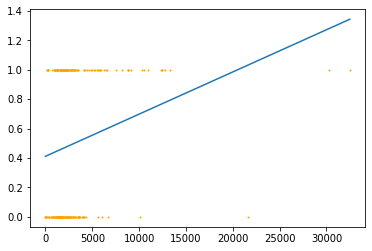

In [0]:
dataAllBodyLength = dataAll.copy()
for index, row in dataAllBodyLength.iterrows():
    textLength = len(row['text'])
    dataAllBodyLength.at[index, 'text_length'] = textLength


import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
linearRegressionBodyLength = LinearRegression(fit_intercept=True)

A = np.array(list(dataAllBodyLength.text_length))
B = np.array(list(dataAllBodyLength.veracity))

linearRegressionBodyLength.fit(A[:, np.newaxis], B)

xfit = np.linspace(-1, max(dataAllBodyLength.text_length), 1000)
yfit = linearRegressionBodyLength.predict(xfit[:, np.newaxis])

plt.scatter(A, B, s=1, c="orange")
plt.plot(xfit, yfit);

print("Model slope:    ", linearRegressionBodyLength.coef_[0])
print("Model intercept:", linearRegressionBodyLength.intercept_)
print("R2 score:", linearRegressionBodyLength.score(A[:, np.newaxis], B))

In [0]:
for index, row in dataTrain.iterrows():
    textLength = len(row['text'])
    dataTrain.at[index, 'text_length'] = textLength

for index, row in dataTest.iterrows():
    textLength = len(row['text'])
    dataTest.at[index, 'text_length'] = textLength

from sklearn import linear_model
from sklearn import linear_model

logClassifierBodyLength = linear_model.LogisticRegression(solver='liblinear', C=17/1000, random_state=111)
logClassifierBodyLength.fit(dataTrain['text_length'].values.reshape(-1, 1), dataTrain['veracity'].values)

predicted = logClassifierBodyLength.predict(dataTest['text_length'].values.reshape(-1, 1))

from sklearn import metrics
print(metrics.accuracy_score(dataTest['veracity'].values.reshape(-1, 1), predicted))

0.5


In [0]:
import pickle

def DATAMINERS_getBodyLengthScore(length): # return between 0 and 1, being 0 = True,  1 = Fake
    x = np.array(length).reshape(-1, 1)
    with open('/content/drive/My Drive/junteng_dev/data_set/log_classifier_body_length.pkl' , 'rb') as f:
        logClassifierBodyLength = pickle.load(f)
    predicted = logClassifierBodyLength.predict(x)
    predicedProb = logClassifierBodyLength.predict_proba(x)[:,1]
    #return int(predicted), float(predicedProb)
    return 1 - float(predicedProb)

DATAMINERS_getBodyLengthScore(12000)

0.08017203680544827

#10 : Word Frequency

In [0]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics

class WordFrequency():

    def __init__(self):        
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        columnNames = ["id", "label", "statement", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"]
        dataTrain = pd.read_csv(dataset_path + "/train.tsv", sep='\t', header=None, names = columnNames)
        dataValidate = pd.read_csv(dataset_path  + "/valid.tsv", sep='\t', header=None, names = columnNames)
        dataTest = pd.read_csv(dataset_path + "/test.tsv", sep='\t', header=None, names = columnNames)
        
        #dropping columns
        columnsToRemove = ['id','subject', 'speaker', 'context','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataValidate = dataValidate.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)

        def convertMulticlassToBinaryclass(r):
            v = r['label']
            if (v == 'true'):
                return 'true'
            if (v == 'mostly-true'):
                return 'true'
            if (v == 'half-true'):
                return 'true'
            if (v == 'barely-true'):
                return 'false'
            if (v == 'false'):
                return 'false'
            if (v == 'pants-fire'):
                return 'false'
        dataTrain['label'] = dataTrain.apply(convertMulticlassToBinaryclass, axis=1)
        dataValidate['label'] = dataValidate.apply(convertMulticlassToBinaryclass, axis=1)
        dataTest['label'] = dataTest.apply(convertMulticlassToBinaryclass, axis=1)
        

    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')
        train_tfidf = tfidfV.fit_transform(dataTrain['statement'].values)
        test_tfidf = tfidfV.fit_transform(dataTest['statement'].values)

#         print('TF-IDF VECTORIZER')

        ## Removing plurals for the tokens using PorterStemmer
        stemmer = PorterStemmer()
        tfidfVPlurals= tfidfV.get_feature_names()
        tfidfVSingles= [stemmer.stem(plural) for plural in tfidfVPlurals]

        # Applying Set to remove duplicates
        tfidfVTokens = list(set(tfidfVSingles))
#         print('TFIDFV Tokens')
#         print(tfidfVTokens)

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['statement'],dataTrain['label'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['statement'])
        score = metrics.accuracy_score(dataTest['label'], predicted_LogR)
        print("Word Frequency Model Trained - accuracy:   %0.6f" % score)
        

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return bool(predicted), float(predicedProb)

In [0]:
import pickle

def DATAMINERS_getWordFrequencyScore(text):  # return between 0 and 1, being 0 = True,  1 = Fake
    #print(clickBait.predict("Should You bring the money now"))
    with open('/content/drive/My Drive/junteng_dev/data_set/word_frequency.pkl', 'rb') as f:
        wordFrequency = pickle.load(f)
    binaryValue, probValue = wordFrequency.predict(text)
    return (1 - float(probValue))

print(DATAMINERS_getWordFrequencyScore("Says the Annies List political group supports third-trimester abortions on demand."))

0.5104703891221551


#11: Bias

https://pdfs.semanticscholar.org/3722/40da2a416abfb406426af71f084c988ff7d9.pdf

In [0]:
!git clone -b development https://github.com/clips/pattern
%cd pattern
!python setup.py install 

Cloning into 'pattern'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 10989 (delta 0), reused 0 (delta 0), pack-reused 10986
Receiving objects: 100% (10989/10989), 51.04 MiB | 24.05 MiB/s, done.
Resolving deltas: 100% (7303/7303), done.
/content/pattern
running install
running bdist_egg
running egg_info
creating Pattern.egg-info
writing Pattern.egg-info/PKG-INFO
writing dependency_links to Pattern.egg-info/dependency_links.txt
writing requirements to Pattern.egg-info/requires.txt
writing top-level names to Pattern.egg-info/top_level.txt
writing manifest file 'Pattern.egg-info/SOURCES.txt'
writing manifest file 'Pattern.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/pattern
copying pattern/__init__.py -> build/lib/pattern
copying pattern/metrics.py -> build/lib/pattern
c

__Sentiment Analysis__

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import  LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import *
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

class SentimentAnalysis():

    def __init__(self):        
        dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
        columnNames = ["jsonid", "label", "headline_text", "subject", "speaker", "speaker_job_title", "state_info", "party_affiliation", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context","clean", "sentiment_vector","vader_polarity", "sentiment_score"]
        dataTrain = pd.read_csv(dataset_path + "/train_sentiment.csv", sep=',', header=None, names = columnNames)
        dataTest = pd.read_csv(dataset_path + "/test_sentiment.csv", sep=',', header=None, names = columnNames)
        
        #dropping columns
        columnsToRemove = ['jsonid', 'label', 'subject', 'speaker','speaker_job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'sentiment_vector']
        dataTrain = dataTrain.drop(columns=columnsToRemove)
        dataTest = dataTest.drop(columns=columnsToRemove)
        dataTrain = dataTrain.loc[1:] 
        dataTest = dataTest.loc[1:]
        dataTrain = dataTrain.dropna()  
        dataTest = dataTest.dropna() 
    
        tfidfV = TfidfVectorizer(stop_words='english', min_df=5, max_df=30, use_idf=True, smooth_idf=True, token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b')

        self.logR_pipeline = Pipeline([
                ('LogRCV', tfidfV),
                ('LogR_clf',LogisticRegression(solver='liblinear', C=32/100))
                ])

        self.logR_pipeline.fit(dataTrain['headline_text'],dataTrain['vader_polarity'])
        predicted_LogR = self.logR_pipeline.predict(dataTest['headline_text'])
        score = metrics.accuracy_score(dataTest['vader_polarity'], predicted_LogR)
        print("Sentiment Analysis Model Trained - accuracy:   %0.6f" % score)

    def predict(self, text):
        predicted = self.logR_pipeline.predict([text])
        predicedProb = self.logR_pipeline.predict_proba([text])[:,1]
        return float(predicedProb)

__[Flesch–Kincaid Grade Level](https://https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests)__
<br>
It is a readability tests designed to indicate how difficult a passage in English is to understand. 

Flesch–Kincaid grade levels are used extensively in the field of education. The "Flesch–Kincaid Grade Level Formula" instead presents a score as a U.S. grade level, making it easier for teachers, parents, librarians, and others to judge the readability level of various books and texts.

Due to the grade level formula's construction, the score does not have an upper bound. The formula emphasises sentence length over word length. By creating one-word strings with hundreds of random characters, grade levels may be attained that are hundreds of times larger than high school completion in the United States.

In [0]:
from builtins import zip
from builtins import str
from builtins import range
from past.utils import old_div
from builtins import object
import json
import multiprocessing
import os
import re
import sys
from collections import OrderedDict
from decorator import contextmanager

In [0]:
def split_into_sentences(text):
    caps = "([A-Z])"
    prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
    suffixes = "(Inc|Ltd|Jr|Sr|Co)"
    starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
    acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
    websites = "[.](com|net|org|io|gov)"
    digits = "([0-9])"

    text = " " + text + "  "
    text = re.sub(prefixes, "\\1<prd>", text)
    text = re.sub(websites, "<prd>\\1", text)
    if "Ph.D" in text:
        text = text.replace("Ph.D.", "Ph<prd>D<prd>")
    if "e.g." in text:
        text = text.replace("e.g.", "e<prd>g<prd>")
    if "i.e." in text:
        text = text.replace("i.e.", "i<prd>e<prd>")
    text = re.sub("\s" + caps + "[.] ", " \\1<prd> ", text)
    text = re.sub(acronyms + " " + starters, "\\1<stop> \\2", text)
    text = re.sub(caps + "[.]" + caps + "[.]" + caps + "[.]", "\\1<prd>\\2<prd>\\3<prd>", text)
    text = re.sub(caps + "[.]" + caps + "[.]", "\\1<prd>\\2<prd>", text)
    text = re.sub(" " + suffixes + "[.] " + starters, " \\1<stop> \\2", text)
    text = re.sub(" " + suffixes + "[.]", " \\1<prd>", text)
    text = re.sub(" " + caps + "[.]", " \\1<prd>", text)
    text = re.sub(digits + "[.]" + digits, "\\1<prd>\\2", text)
    if "”" in text:
        text = text.replace(".”", "”.")
    if "\"" in text:
        text = text.replace(".\"", "\".")
    if "!" in text:
        text = text.replace("!\"", "\"!")
    if "?" in text:
        text = text.replace("?\"", "\"?")
    text = text.replace("\n", " <stop>")
    text = text.replace(".", ".<stop>")
    text = text.replace("?", "?<stop>")
    text = text.replace("!", "!<stop>")
    text = text.replace("<prd>", ".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    sentences = [s for s in sentences if len(s) >= 2]
    return sentences

def sentence_count(text):
    ignore_count = 0
    sentences = split_into_sentences(text)
    for sentence in sentences:
        if lexicon_count(sentence) <= 2:
            ignore_count = ignore_count + 1
    sentence_cnt = len(sentences) - ignore_count
    if sentence_cnt < 1:
        sentence_cnt = 1
    return sentence_cnt

def syllable_count(text):
    exclude = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    count = 0
    vowels = 'aeiouy'
    text = text.lower()
    text = "".join(x for x in text if x not in exclude)

    if text is None:
        return 0
    elif len(text) == 0:
        return 0
    else:
        if text[0] in vowels:
            count += 1
        for index in range(1, len(text)):
            if text[index] in vowels and text[index - 1] not in vowels:
                count += 1
        if text.endswith('e'):
            count -= 1
        if text.endswith('le'):
            count += 1
        if count == 0:
            count += 1
        count = count - (0.1 * count)
        return count

def lexicon_count(text, removepunct=True):
    exclude = '!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    if removepunct:
        text = ''.join(ch for ch in text if ch not in exclude)
    count = len(text.split())
    return count

def avg_sentence_length(text):
    lc = lexicon_count(text)
    sc = sentence_count(text)
    a_s_l = float(old_div(lc, sc))
    return round(a_s_l, 1)

def avg_syllables_per_word(text):
    syllable = syllable_count(text)
    words = lexicon_count(text)
    try:
        a_s_p_w = old_div(float(syllable), float(words))
        return round(a_s_p_w, 1)
    except ZeroDivisionError:
        # print "Error(ASyPW): Number of words are zero, cannot divide"
        return 1

def flesch_kincaid_grade(text):
    if sys.version_info < (3, 0):
        text = text.decode('ascii', 'ignore')
        
    a_s_l = avg_sentence_length(text)
    a_s_w = avg_syllables_per_word(text)
    f_k_r_a = float(0.39 * a_s_l) + float(11.8 * a_s_w) - 15.59
    return round(f_k_r_a, 1)


__Negative Perspective Analysis__

Determine the degree of negative perspective of text
Returns an float for score (higher is more negative)

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

def check_neg_persp(input_text, include_nt=True):
    if sys.version_info < (3, 0):
        text = text.decode('ascii', 'ignore')
    sa = SentimentIntensityAnalyzer()
    text_nohyph = input_text.replace("-", " ")  
    txt_lwr = str(text_nohyph).lower()
    input_words = ''.join(ch for ch in txt_lwr if ch not in '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~').split()
    vader_score = sa.polarity_scores(input_text)
    vader_neg =  vader_score['neg']
    vader_compound = vader_score['compound']

    neg_persp_score = 0.0
    neg_words = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
                  "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
                  "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
                  "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
                  "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
                  "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
                  "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
                  "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

    for word in neg_words:
        if word in input_words:
            neg_persp_score += 1
    if include_nt:
        for word in input_words:
            if "n't" in word and word not in neg_words:
                neg_persp_score += 1
    if vader_neg > 0.0:
        neg_persp_score += vader_neg
    if vader_compound < 0.0:
        neg_persp_score += abs(vader_compound)
    return neg_persp_score

__Degree of Certainty Analysis__

Checking if a Statement is a Fact.
It returns a value between -1 to 1. For facts, it returns a value greater than 0.5.
Similarly, for a sentence which is not certain returned a value around 0.0.


In [0]:
from pattern.en import Sentence, parse, modality, pprint

def check_certainty(text):
    if sys.version_info < (3, 0):
        text = text.decode('ascii', 'ignore')
        
    sentence = parse(text, relations=True, lemmata=True)
    sentence_obj = Sentence(sentence)
    return round(modality(sentence_obj), 4)

__Lexicon Analysis__

In [0]:
dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
src = dataset_path + "/lexicon.json"
exampleJSONFile = open(src)
with open(src) as file:
    ref_lexicons = json.loads(file.read())

##### List of presupposition verbs (comprised of Factive, Implicative, Coherence, Causation, & Assertion markers):
### Factive verbs derived from:
# Paul Kiparsky and Carol Kiparsky. 1970. Fact. In M.Bierwisch and K.E.Heidolph, editors, Progress in
#  Linguistics, pages 143–173.Mouton, The Hague.
### Implicative verbs derived from
# Lauri Karttunen. 1971. Implicative verbs. Language, 47(2):340–358.
##### List of coherence markers derived from:
# Knott, Alistair. 1996. A Data-Driven Methodology for Motivating a Set of
#  Coherence Relations. Ph.D. dissertation, University of Edinburgh, UK.
##### List of assertive derived from:
# Joan B. Hooper. 1975. On assertive predicates. In J. Kimball, editor,
#  Syntax and Semantics, volume 4, pages 91–124. Academic Press, New York.
##### List of Causation words from LIWC
#########################################################################
presup = ref_lexicons['presupposition']

##### List of hedge words derived from:
# Ken Hyland. 2005. Metadiscourse: Exploring Interaction in Writing.
# Continuum, London and New York.
##### List of tentative words from LIWC
##### List of NPOV hedge & "weasel" words to watch from
# https://en.wikipedia.org/wiki/Wikipedia:Manual_of_Style/Words_to_watch
#########################################################################
doubt = ref_lexicons['doubt_markers']

##### List of biased/partisan words derived from:
# Marta Recasens, Cristian Danescu-Niculescu-Mizil, and Dan Jurafsky. 2013. Linguistic Models for
#     Analyzing and Detecting Biased Language. Proceedings of ACL 2013.
# and
# Gentzkow, Econometrica 2010: What Drives Media Slant? Evidence from U.S. Daily Newspapers
#########################################################################
partisan = ref_lexicons['partisan']

##### List of opinion laden words extracted from:
# Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
#  Sentiment Analysis of Social Media Text. Eighth International Conference on
#  Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
##### List of strong/weak subjective words extracted from:
# Theresa Wilson, Janyce Wiebe and Paul Hoffmann (2005). Recognizing Contextual
# Polarity in Phrase-Level Sentiment Analysis. Proceedings of HLT/EMNLP 2005,
# Vancouver, Canada.
##### List of degree modifiers derived from:
# Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
#  Sentiment Analysis of Social Media Text. Eighth International Conference on
#  Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
#########################################################################
value_laden = ref_lexicons['value_laden']

##### List of figurative expressions derived from:
###English-language idioms
# https://en.wikipedia.org/wiki/English-language_idioms.
# and
### List of English-language metaphors
# https://en.wikipedia.org/wiki/List_of_English-language_metaphors
# and
### List of political metaphors
# https://en.wikipedia.org/wiki/List_of_political_metaphors
### List of NPOV "puffery & peacock" words to watch from
# https://en.wikipedia.org/wiki/Wikipedia:Manual_of_Style/Words_to_watch
#########################################################################
figurative = ref_lexicons['figurative']

##### Lists of attribution bias/actor-observer bias/ultimate attribution markers
# LIWC 3rd person pronouns (combines S/he and They)
# LIWC achievement words
# LIWC work words
attribution = ref_lexicons['attribution']

#### List of self reference pronouns from LIWC
self_refer = ref_lexicons['self_reference']

In [0]:
def count_feature_freq(feature_list, input_text):
    cnt = 0
    text_nohyph = input_text.replace("-", " ")  
    txt_lwr = str(text_nohyph).lower()
    tokens_list = ''.join(ch for ch in txt_lwr if ch not in '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~').split()
    # count unigrams
    for w in tokens_list:
        if w in feature_list:
            cnt += 1
        # count wildcard features
        for feature in feature_list:
            if str(feature).endswith('*') and str(w).startswith(feature[:-1]):
                cnt += 1
    # count n_gram phrase features
    for feature in feature_list:
        if " " in feature and feature in txt_lwr:
            cnt += str(txt_lwr).count(feature)
    return cnt

__Extract Bias Features__

get all the bias features score and return them in a list

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler
import nltk.sentiment
import warnings
warnings.filterwarnings('ignore')

sentiment_analyzer = SentimentAnalysis()
sa = SentimentIntensityAnalyzer()

Sentiment Analysis Model Trained - accuracy:   0.943918


In [0]:
def extract_bias_features_from_dataframe(df):
    bias_df = df.copy()

    bias_df['fk_gl'] = df['headline_text'].apply(flesch_kincaid_grade)
    bias_df['vader_sentiment'] = df['headline_text'].apply(sentiment_analyzer.predict)
    bias_df['neg_persp'] = df['headline_text'].apply(check_neg_persp)
    bias_df['certainty'] = df['headline_text'].apply(check_certainty)

    ## LEXICON LEVEL MEASURES
    # presupposition markers
    bias_df['presup_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(presup, x))

    # doubt markers
    bias_df['doubt_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(doubt, x))

    # partisan words and phrases
    bias_df['partisan_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(partisan, x))

    # subjective value laden word count
    bias_df['value_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(value_laden, x))

    # figurative language markers
    bias_df['figurative_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(figurative, x))

    # attribution markers
    bias_df['attribution_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(attribution, x))

    # self reference pronouns
    bias_df['self_refer_cnt'] = df['headline_text'].apply(lambda x: count_feature_freq(self_refer, x))

    bias_df_std = bias_df.iloc[:, 2:]
    bias_df_scale = StandardScaler().fit_transform(bias_df_std)
    bias_df_std = pd.DataFrame(bias_df_scale , index=bias_df_std.index, columns=bias_df_std.columns)

    bias_df_std['label'] = bias_df['label']
    return bias_df, bias_df_std

###__Bias Fake News Dataset__

[Fake News Datset Source](https://www.kaggle.com/mrisdal/fake-news/data)

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
bias_extracted_std_file = dataset_path + "/bias_extracted_std.csv"
bias_extracted_file = dataset_path + "/bias_extracted.csv"

if path.exists(bias_extracted_file) or path.exists(bias_extracted_file):
    bias_extracted = pd.read_csv(bias_extracted_file)
    bias_extracted_std = pd.read_csv(bias_extracted_std_file)
else:
    bias_df = pd.read_csv(dataset_path + "/bias.csv")
    bias_news_df = pd.DataFrame(columns = ['headline_text', 'label']) 
    bias_news_df['label'] = bias_df['type']
    bias_news_df['headline_text'] = bias_df['text']
    bias_news_df = bias_news_df.dropna()
    bias_extracted, bias_extracted_std = extract_bias_features_from_dataframe(bias_news_df)
    bias_extracted.to_csv(bias_extracted_file , sep=',', index=False)
    bias_extracted_std.to_csv(bias_extracted_std_file, sep=',', index=False) 

####__Dataset balance__

In [0]:
from sklearn.utils import resample
bias_bias = bias_extracted_std[bias_extracted_std['label'] == 'bias']
bias_bs = bias_extracted_std[bias_extracted_std['label'] == 'bs']
bias_conspiracy = bias_extracted_std[bias_extracted_std['label'] == 'conspiracy']
bias_fake = bias_extracted_std[bias_extracted_std['label'] == 'fake']
bias_hate = bias_extracted_std[bias_extracted_std['label'] == 'hate']
bias_junksci = bias_extracted_std[bias_extracted_std['label'] == 'junksci']
bias_satire = bias_extracted_std[bias_extracted_std['label'] == 'satire']
bias_state = bias_extracted_std[bias_extracted_std['label'] == 'state']

bias_bias_downsampled = resample(bias_bias, 
                                 replace=False,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result

bias_bs_downsampled = resample(bias_bs, 
                                 replace=False,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result

bias_fake_upsampled = resample(bias_fake, 
                                 replace=True,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result

bias_junksci_upsampled = resample(bias_junksci, 
                                 replace=True,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result                        

bias_state_upsampled = resample(bias_state, 
                                 replace=True,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result                        

bias_satire_upsampled = resample(bias_satire, 
                                 replace=True,    # sample without replacement
                                 n_samples=329,     # to match minority class
                                 random_state=123) # reproducible result 

bias_extracted_std = pd.concat([bias_bias_downsampled, 
                                 bias_bs_downsampled, 
                                 bias_conspiracy, 
                                 bias_fake_upsampled, 
                                 bias_hate,
                                 bias_junksci_upsampled,
                                 bias_state_upsampled,
                                 bias_satire_upsampled])

In [0]:
from sklearn.model_selection import train_test_split

X = bias_extracted_std.iloc[:, :11]
y = bias_extracted_std.iloc[:, 11]
X_bias_train, X_bias_test, y_bias_train, y_bias_test = train_test_split(X, y, test_size=0.4, random_state=42)

####__XGBoost Feature Importance and Feature Selection__

In [0]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn import metrics
import pickle

xgb_model = XGBClassifier(max_depth=7)
xgb_model.fit(X_bias_train, y_bias_train)
dataset_path = "/content/drive/My Drive/junteng_dev/data_set"

with open(dataset_path + '/bias_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
pred_xgboost = xgb_model.predict(X_bias_test)
score = metrics.accuracy_score(y_bias_test, pred_xgboost)
pre_score = metrics.precision_score(y_bias_test, pred_xgboost, average='weighted')
f1 = metrics.f1_score(y_bias_test, pred_xgboost, average='weighted') 
print("XGBoot Model Trained - accuracy: {:.4f}   precision: {:.4f}   F1 Score: {:.4f}".format(score, pre_score, f1))

XGBoot Model Trained - accuracy: 0.6706   precision: 0.6551   F1 Score: 0.6593


In [0]:
pd.crosstab(y_bias_test, pred_xgboost, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,bias,bs,conspiracy,fake,hate,junksci,satire,state,All
True,,,,,,,,,
bias,57,19,29,2,8,5,4,14,138
bs,20,49,22,1,21,13,6,11,143
conspiracy,25,11,67,1,4,3,2,5,118
fake,0,0,0,131,0,0,0,0,131
hate,15,31,9,1,32,4,5,4,101
junksci,0,0,0,0,5,120,0,0,125
satire,0,9,11,0,0,0,113,2,135
state,3,8,3,0,0,0,0,115,129
All,120,127,141,136,70,145,130,151,1020


####__Classification Metrics__

|Classificaion| Accuracy Score| Precision Score | F1 Score |
|---|---|---|---|
|XGBoost| 0.6706 | 0.6551 | 0.6593


###__Political Social Media Dataset__

[Political Social Media Dataset Source](https://www.kaggle.com/crowdflower/political-social-media-posts)

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"
media_extracted_std_file = dataset_path + "/media_extracted_std.csv"
media_extracted_file = dataset_path + "/media_extracted.csv"

if path.exists(bias_extracted_file) or path.exists(bias_extracted_file):
    media_extracted = pd.read_csv(media_extracted_file)
    media_extracted_std = pd.read_csv(media_extracted_std_file)
else:
    media_df = pd.read_csv(dataset_path  + "/political_social_media.csv', encoding='latin1")
    media_news_df = pd.DataFrame(columns = ['headline_text', 'label']) 
    media_news_df['label'] = media_df['bias']
    media_news_df['headline_text'] = media_df['text']
    media_news_df = media_news_df.dropna()
    media_extracted, media_extracted_std = extract_bias_features_from_dataframe(media_news_df)
    media_extracted.to_csv(media_extracted_std_file, sep=',', index=False)
    media_extracted_std.to_csv(media_extracted_file, sep=',', index=False) 

####__Dataset balance__

In [0]:
from sklearn.utils import resample

media_neutral = media_extracted_std[media_extracted_std['label'] == 'neutral']
media_partisan = media_extracted_std[media_extracted_std['label'] == 'partisan']

media_neutral_downsampled = resample(media_neutral, 
                                 replace=False,    # sample without replacement
                                 n_samples=1310,     # to match minority class
                                 random_state=123) # reproducible result

media_extracted_std = pd.concat([media_neutral_downsampled, media_partisan])

In [0]:
from sklearn.model_selection import train_test_split

X = media_extracted_std.iloc[:, :11]
y = media_extracted_std.iloc[:, 11]
X_media_train, X_media_test, y_media_train, y_media_test = train_test_split(X, y, test_size=0.4, random_state=42)

####__XGBoost Feature Importance and Feature Selection__

In [0]:
dataset_path = "/content/drive/My Drive/junteng_dev/data_set"

xgb_model = XGBClassifier(max_depth=3)
xgb_model.fit(X_media_train, y_media_train)

with open(dataset_path + "/media_xgboost.pkl", 'wb') as f:
    pickle.dump(xgb_model, f)
pred_xgboost = xgb_model.predict(X_media_test)
score = metrics.accuracy_score(y_media_test, pred_xgboost)
pre_score = metrics.precision_score(y_media_test, pred_xgboost, average='weighted')
f1 = metrics.f1_score(y_media_test, pred_xgboost, average='weighted') 
print("XGBoot Model Trained - accuracy: {:.4f}   precision: {:.4f}   F1 Score: {:.4f}".format(score, pre_score, f1))

XGBoot Model Trained - accuracy: 0.6269   precision: 0.6270   F1 Score: 0.6265


In [0]:
pd.crosstab(y_media_test, pred_xgboost, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,neutral,partisan,All
True,,,
neutral,349,182,531
partisan,209,308,517
All,558,490,1048


0: fk_gl - 0.083017
1: vader_sentiment - 0.083639
2: neg_persp - 0.283886
3: certainty - 0.086178
4: presup_cnt - 0.069015
5: doubt_cnt - 0.093660
6: partisan_cnt - 0.087762
7: value_cnt - 0.060404
8: figurative_cnt - 0.000000
9: attribution_cnt - 0.068294
10: self_refer_cnt - 0.084144


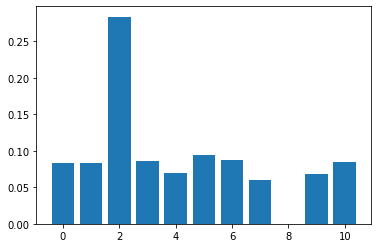

In [0]:
for i in range(len(X_media_train.columns)):
    print('{}: {} - {:.6f}'.format(i, X_media_train.columns[i], xgb_model.feature_importances_[i]))
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

####__Classification Metrics__

|Classificaion| Accuracy Score| Precision Score | F1 Score |
|---|---|---|---|
|XGBoost| 0.6269 | 0.6270| 0.6197

###__Liar Liar Dataset__

In [0]:
import pickle
import os.path
from os import path

dataset_path = "/content/drive/My Drive/junteng_dev/data_set"

fake_train_std_file = "/content/drive/My Drive/junteng_dev/data_set/train_extracted_std.csv"
fake_train_file = "/content/drive/My Drive/junteng_dev/data_set/train_extracted.csv"
fake_test_std_file = "/content/drive/My Drive/junteng_dev/data_set/test_extracted_std.csv"
fake_test_file = "/content/drive/My Drive/junteng_dev/data_set/test_extracted.csv"

if all([path.exists(fake_train_std_file), path.exists(fake_train_file), path.exists(fake_test_std_file), path.exists(fake_test_file)]):
    fake_train_extracted_std = pd.read_csv(fake_train_std_file)
    fake_test_extracted_std = pd.read_csv(fake_test_std_file)
    fake_train_extracted = pd.read_csv(fake_train_file)
    fake_test_extracted = pd.read_csv(fake_test_file)
else:
    fake_train_processed = pd.read_csv('/content/drive/My Drive/junteng_dev/data_set/train_processed.csv', sep=',')
    fake_test_processed = pd.read_csv('/content/drive/My Drive/junteng_dev/data_set/test_processed.csv', sep=',')
    columns_to_remove = ['Unnamed: 0', 
                        'jsonid', 
                        'subject', 
                        'speaker',
                        'speakerjobtitle', 
                        'stateinfo', 
                        'partyaffiliation',
                        'barelytruecounts',
                        'falsecounts', 
                        'halftruecounts', 
                        'mostlytrueocunts',
                        'pantsonfirecounts', 
                        'context']
    fake_train_processed = fake_train_processed.drop(columns=columns_to_remove)
    fake_test_processed = fake_test_processed.drop(columns=columns_to_remove)
    fake_train_processed = fake_train_processed.dropna()  
    fake_test_processed = fake_test_processed.dropna() 
    fake_train_extracted_std, fake_train_extracted = extract_bias_features_from_dataframe(fake_train_processed)
    fake_train_extracted.to_csv("/content/drive/My Drive/junteng_dev/data_set/train_extracted.csv", sep=',', index=False)
    fake_train_extracted_std.to_csv("/content/drive/My Drive/junteng_dev/data_set/train_extracted_std.csv", sep=',', index=False)
    fake_test_extracted, fake_test_extracted_std = extract_bias_features_from_dataframe(fake_test_processed)
    fake_test_extracted.to_csv("/content/drive/My Drive/junteng_dev/data_set/test_extracted.csv", sep=',', index=False)
    fake_test_extracted_std.to_csv("/content/drive/My Drive/junteng_dev/data_set/test_extracted_std.csv", sep=',', index=False)


In [0]:
from sklearn.model_selection import train_test_split

X_fake_train = fake_train_extracted.iloc[:, 3:14]
y_fake_train = fake_train_extracted.iloc[:, 0]
X_fake_test = fake_test_extracted.iloc[:, 3:14]
y_fake_test = fake_test_extracted.iloc[:, 0]

In [0]:
xgb_model = XGBClassifier(max_depth=14)
xgb_model.fit(X_bias_train, y_bias_train)
X_fake_train_bias= xgb_model.predict(X_fake_train)
X_fake_test_bias = xgb_model.predict(X_fake_test)

xgb_model = XGBClassifier(max_depth=3)
xgb_model.fit(X_media_train, y_media_train)
X_fake_train_media = xgb_model.predict(X_fake_train)
X_fake_test_media = xgb_model.predict(X_fake_test)

X_fake_train['bias'] = X_fake_train_bias
X_fake_train['media'] = X_fake_train_media

X_fake_test['bias'] = X_fake_test_bias
X_fake_test['media'] = X_fake_test_media

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X_fake_train['bias label'] = le.fit_transform(X_fake_train['bias'])
X_fake_train['media label'] = le.fit_transform(X_fake_train['media'])
X_fake_test['bias label'] = le.fit_transform(X_fake_test['bias'])
X_fake_test['media label'] = le.fit_transform(X_fake_test['media'])

X_fake_train = X_fake_train.drop(['bias', 'media'] ,axis=1)
X_fake_test = X_fake_test.drop(['bias', 'media'] ,axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler
bias_df_scale = StandardScaler().fit_transform(X_fake_train)
X_fake_train = pd.DataFrame(bias_df_scale , index=X_fake_train.index, columns=X_fake_train.columns)
bias_df_scale = StandardScaler().fit_transform(X_fake_test)
X_fake_test = pd.DataFrame(bias_df_scale , index=X_fake_test.index, columns=X_fake_test.columns)

#####__XGBoost Feature Importance and Feature Selection__

In [0]:
xgb_model = XGBClassifier(max_depth=4)
xgb_model.fit(X_fake_train, y_fake_train)
with open('/content/drive/My Drive/junteng_dev/data_set/liar_xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
pred_xgboost = xgb_model.predict(X_fake_test)
score = metrics.accuracy_score(y_fake_test, pred_xgboost)
pre_score = metrics.precision_score(y_fake_test, pred_xgboost, average='weighted')
f1 = metrics.f1_score(y_fake_test, pred_xgboost, average='weighted') 
print("XGBoot Model Trained - accuracy: {:.4f}   precision: {:.4f}   F1 Score: {:.4f}".format(score, pre_score, f1))

XGBoot Model Trained - accuracy: 0.2115   precision: 0.1726   F1 Score: 0.1805


Confustion Matrix

In [0]:
pd.crosstab(y_fake_test, pred_xgboost, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,barely-true,false,half-true,mostly-true,pants-fire,true,All
True,,,,,,,
barely-true,4,61,75,49,3,20,212
false,9,69,89,56,3,23,249
half-true,11,57,106,68,2,21,265
mostly-true,9,59,81,72,2,18,241
pants-fire,4,25,25,28,0,10,92
true,12,55,75,49,0,17,208
All,49,326,451,322,10,109,1267


${normalized\ accuracy} = \frac {True Positive} {(True Positive + False Negative)} + \frac {True Negative} {(True Negative + False Positive)} - 1$


Most Accurate Predition is Half-True, we use it to calculate the weight: 

$\frac {106} {(106 + 159 )} + \frac {657} {(657 + 345 )} - 1 = 0.05$




0: fk_gl - 0.078082
1: vader_sentiment - 0.087821
2: neg_persp - 0.084985
3: certainty - 0.099399
4: presup_cnt - 0.075793
5: doubt_cnt - 0.082891
6: partisan_cnt - 0.071537
7: value_cnt - 0.080153
8: figurative_cnt - 0.124440
9: attribution_cnt - 0.069431
10: self_refer_cnt - 0.075040
11: bias label - 0.070427
12: media label - 0.000000


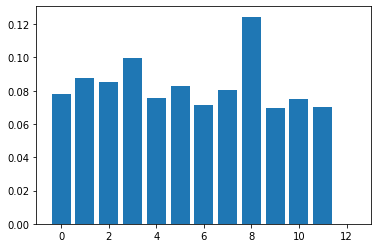

In [0]:
for i in range(len(X_fake_train.columns)):
    print('{}: {} - {:.6f}'.format(i, X_fake_train.columns[i], xgb_model.feature_importances_[i]))
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()

####__Classification Metrics__

|Classificaion| Accuracy Score| Precision Score | F1 Score |
|---|---|---|---|
|XGBoost|         0.2147 | 0.2245   | 0.1841

__Accuracy Score__

|Classificaion                 |  XGBoost
|---|---
|Bias Fake News Dataset        |  0.6706  
|Political Social Media Dataset|  0.6269  
|Liar Liar Dataset             |  0.2186  


__Precision Score__

|Classificaion                 |  XGBoost | 
|---|---|
|Bias Fake News Dataset        |  0.6551  | 
|Political Social Media Dataset|  0.6270  |
|Liar Liar Dataset             |  0.2186  | 

__F1 Score__

|Classificaion                 |  XGBoost |
|---|---|
|Bias Fake News Dataset        |  0.6593  | 
|Political Social Media Dataset|  0.6197  |
|Liar Liar Dataset             |  0.2186  | 

###__Feature Class__

In [0]:
import pickle
from sklearn import preprocessing

sentiment_analyzer = SentimentAnalysis()
class BiasAnalysis():
    def __init__(self):
        with open('/content/drive/My Drive/junteng_dev/data_set/liar_xgboost.pkl', 'rb') as f:
            self.fake_news_model = pickle.load(f)
        with open('/content/drive/My Drive/junteng_dev/data_set/bias_xgboost.pkl', 'rb') as f:
            self.bias_fake_xgboost = pickle.load(f)
        with open('/content/drive/My Drive/junteng_dev/data_set/media_xgboost.pkl', 'rb') as f:
            self.media_fake_xgboost = pickle.load(f)
        self.le = preprocessing.LabelEncoder()

    def predict(self, text):
        df = pd.DataFrame({
            "fk_gl": [flesch_kincaid_grade(text)], 
            "vader_sentiment": [sentiment_analyzer.predict(text)],
            "neg_persp": [check_neg_persp(text)],
            "certainty": [check_certainty(text)],
            "presup_cnt": [count_feature_freq(presup, text)],
            "doubt_cnt": [count_feature_freq(doubt, text)],
            "partisan_cnt": [count_feature_freq(partisan, text)],
            "value_cnt": [count_feature_freq(value_laden, text)],
            "figurative_cnt": [count_feature_freq(figurative, text)],
            "attribution_cnt": [count_feature_freq(attribution, text)],
            "self_refer_cnt": [count_feature_freq(self_refer, text)],
            }, index=[0])
        bias_label = self.bias_fake_xgboost.predict(df)
        media_label = self.media_fake_xgboost.predict(df)
        df['bias label'] = bias_label 
        df['media label'] = media_label
        df['bias label'] = self.le.fit_transform(df['bias label'])
        df['media label'] = self.le.fit_transform(df['media label'])

        result = self.fake_news_model.predict(df)[0]
        result_proba = self.fake_news_model.predict_proba(df)[:,1][0]
        return result, result_proba

Sentiment Analysis Model Trained - accuracy:   0.943918


In [0]:
ba = BiasAnalysis()
liar_df = pd.read_csv("/content/drive/My Drive/junteng_dev/data_set/train_processed.csv")

In [0]:
import pickle
def SEERs_getBiasSCore(text): 
    bias_df = pd.DataFrame({
                    "fk_gl": [flesch_kincaid_grade(text)], 
                    "vader_sentiment": [sentiment_analyzer.predict(text)],
                    "neg_persp": [check_neg_persp(text)],
                    "certainty": [check_certainty(text)],
                    "presup_cnt": [count_feature_freq(presup, text)],
                    "doubt_cnt": [count_feature_freq(doubt, text)],
                    "partisan_cnt": [count_feature_freq(partisan, text)],
                    "value_cnt": [count_feature_freq(value_laden, text)],
                    "figurative_cnt": [count_feature_freq(figurative, text)],
                    "attribution_cnt": [count_feature_freq(attribution, text)],
                    "self_refer_cnt": [count_feature_freq(self_refer, text)],
                    'bias label': 1, 
                    'media label': 0
                    }, index=[0])
    with open('/content/drive/My Drive/junteng_dev/data_set/liar_xgboost.pkl', 'rb') as f:
        fake_news_model = pickle.load(f)
    result = fake_news_model.predict(bias_df)
    result_proba = fake_news_model.predict_proba(bias_df)[:,1][0]
    return result_proba

In [0]:
text = liar_df.sample()

SEERs_getBiasSCore(text['clean'].values[0])

0.07498383

# FINAL COMBINED MODEL

###  <span style="color:red"> ITEARTION 2: Need to add all 11 features and make a polynomial equation and do performance analysis on it. </span>

## Polynomial Equation

In [0]:
import warnings
warnings.filterwarnings('ignore')

def getRelevance(text, headline="", numAuthors = 0, source = "", party =""):
    accur = [0.84, 0.56, 0.95, 0.35,  0.1 ,0.54, 0.98, 0.71, 0.6, 1, 0.05] # using the (normalized) accuracy as weigths
    w = [float(i)/sum(accur) for i in accur]
    sumW = 0
    prob = []
    prob.append(w[0] * DATAMINERS_getAuthorScore(numAuthors))
    sumW += w[0]
    if ( (headline != "") & (party != "")):
        prob.append(w[1] * DATAMINERS_getPartyAffiliationScore(headline, party))
        sumW += w[1]
    if (headline != ""):
        prob.append(w[2] * DATAMINERS_getClickbaitScore(headline))
        sumW += w[2]
    if (headline != ""):
        prob.append(w[3] * DATAMINERS_getSentimentAnalysisScore(text))
        sumW += w[3]
    if (headline != ""):
        prob.append(w[4] * DATAMINERS_getLDATopicModellingScore(headline))
        sumW += w[4]
    if (headline != ""):
        prob.append(w[5] * DATAMINERS_getSensationalismScore(headline))
        sumW += w[5]
    if (headline != ""):
        prob.append(w[6] * DATAMINERS_getSpamScore(headline))
        sumW += w[6]
    prob.append(w[7] * DATAMINERS_getBodyLengthScore(len(text)))
    sumW += w[7]
    prob.append(w[8] * DATAMINERS_getWordFrequencyScore(text))
    sumW += w[8]
    if (party != ""):
        prob.append(w[9] * DATAMINERS_getSourceReputationScore(source))
        sumW += w[9]

    #Bias
    prob.append(w[10] * SEERs_getBiasSCore(text))
    sumW += w[10]

    probTotal = sum(prob[0:len(prob)]) / sumW
    return probTotal

###Google Search API

In [0]:
!pip install tweet-preprocessor
!pip install google-api-python-client

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=30c0da8dde818c7273ece1a8994de8a80abc074eaa1d480fd87ce38871d2af76
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor


In [0]:
import tweepy
import json
from googleapiclient.discovery import build

In [0]:
class GoogleSearch(object):
    def __init__(self, api_key, cse_id):
        self.__api_key = api_key
        self.__cse_id = cse_id
        self.service = build("customsearch", "v1", developerKey=api_key)
    
    def search(self, search_term, **kwargs):
        self.__data = self.service.cse().list(q=search_term, cx=self.__cse_id, **kwargs).execute()
    
    def get_results(self):
        return self.__data
    
    def get_search_url(self):
        url_list = list()
        if "items" in self.__data:
            for item in self.__data['items']:
                url_list.append(item['link'])
        return url_list

#Dynomodb

In [0]:
AWS_ACCESS_KEY_ID = " "
AWS_SECRET_ACCESS_KEY = " "
AWS_REGION = 'us-east-1'

In [0]:
import uuid
import boto3
from datetime import datetime
from boto3.dynamodb.conditions import Key, Attr
from botocore.exceptions import ClientError

class DynamoDB(object):
    def __init__(self, api_key, secret_key, table_name, aws_region='us-east-1'):
        try:
            self.__session = boto3.Session(
                aws_access_key_id = api_key,
                aws_secret_access_key = secret_key,
                region_name = aws_region,
            )
            self.__dynamodb = self.__session.resource('dynamodb')
            self.__table = self.__dynamodb.Table(table_name)
        except ClientError as e:
            print(e.response['Error']['Message'])

    def _convert_timestamp(self, response_data):
        for item in response_data:
            time_str = datetime.fromtimestamp(item['timestamp']).strftime('%Y-%m-%d')
            item['timestamp'] = time_str
        return response_data

    def _convert_timestring(self, timestring):
        for format in ['%Y-%m-%d', '%Y/%m/%d', '%Y%m%d', '%Y %m %d']:
            try:
                timestamp = datetime.strptime(timestring, format).strftime('%s')
                return int(timestamp)
            except ValueError as e:
                pass

    def insert(self, **kwargs):
        item_id = uuid.uuid4().hex
        if 'item_id' not in kwargs.keys():
            kwargs['item_id'] = item_id
        if 'timestamp' not in kwargs.keys():
            kwargs['timestamp'] = 0
        else:
            kwargs['timestamp'] = self._convert_timestring(kwargs['timestamp'])
        try:
            response = self.__table.put_item(
                Item=kwargs
            )
            return response['ResponseMetadata']
        except ClientError as e:
            return e.response['Error']['Message']

    def search_all(self):
        try:
            response = self.__table.scan()
            data = response['Items']
            while 'LastEvaluatedKey' in response:
                response = self.__table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
                data.extend(response['Items'])
            return data
        except ClientError as e:
            return e.response['Error']['Message']

    def search_by_id(self, item_id):
        try:
            response = slef.__table.query(
                KeyConditionExpression=Key('item_id').eq(item_id),
                ScanIndexForward=True
            )
            return response['Items']
        except ClientError as e:
            return e.response['Error']['Message']            

    def search_by_timestamp(self, timestamp):
        timestamp = self._convert_timestring(timestamp)
        try:
            filtering_exp = Key('timestamp').eq(timestamp)
            response = self.__table.scan(
                FilterExpression=filtering_exp
            )
            return response['Items']
        except ClientError as e:
            return e.response['Error']['Message']

    def search_by_timestamp_range(self, start=None, end=None):
        if not start:
            start = 0
        else:
            start = self._convert_timestring(start)
        if not end:
            end = int(datetime.now().strftime('%s'))
        else:
            end = self._convert_timestring(end)
        try:
            filtering_exp = Key('timestamp').between(start, end)
            response = self.__table.scan(
                FilterExpression=filtering_exp
            )
            return response['Items']
        except ClientError as e:
            return e.response['Error']['Message']

    def delete_by_id(self, item_id):
        records = self.search_by_id(item_id)
        if not records:
            return "No Records Found"
        try:
            response = self.__table.delete_item(
                Key = {
                    'item_id': records[0]['item_id'],
                    'timestamp': records[0]['timestamp']
                }
            )
            return response['ResponseMetadata']
        except ClientError as e:
            return e.response['Error']['Message']

# Article Parsing and Storing

In [0]:
!pip install newspaper3k
!pip uninstall feedparser -y
!pip install feedparser

     |████████████████████████████████| 215kB 3.4MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 7.4MB 7.2MB/s 
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3357 sha256=6ec517c32542fe1eecdda78c4c78ea736ab8823585a31d93d9fcdb6337c785e8
  Stored in directory: /root/.cache/pip/wheels/de/03/ca/778e3a7a627e3d98836cc890e7cb40c7575424cfd3340f40ed
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-cp36-none-any.whl size=13539 sha256=df7381969aa72315472b17d2e0845b4f197e44b42be9c58c098355b900f759e7
  Stored in directory: /root/.cache/pip/wheels/81/2b/43/a02ede72324dd40cdd7ca53aad718c7710628e91b8b0dc0f02
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=c797571ce623cc5238bf879559d5de9d4b5000e046c811c5a7f2d0a8863c9ee5
  Stored in directory: /root/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for sgmllib3k: filen

In [0]:
search_term = "new+york+covid19"
GOOGLE_API_KEY = " "
GOOGLE_CSE_ID = " "

google_search = GoogleSearch(GOOGLE_API_KEY, GOOGLE_CSE_ID)
google_search.search(search_term)
search_url = google_search.get_search_url()

Extract Data From Articles URL and save into DynamoDB

In [0]:
from newspaper import Article
from datetime import datetime

dynamodb_client = DynamoDB(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, 'timeline')

for url in search_url:    
    try: 
        article = Article(url)
        article.download()
        article.parse()
        content_txt = article.text
        content_title = article.title
        num_authors = len(article.authors)
        source_url = article.source_url
        time_str = article.publish_date
        if not time_str:
            time_str = datetime.now().strftime('%Y-%m-%d')
        else:
            time_str = time_str.strftime('%Y-%m-%d')
        relevance_sorce = str(getRelevance(content_txt, content_title, num_authors, source_url))
        print(relevance_sorce)
        article.nlp()
        insert_item = {
            "abstract": article.summary,
            "authors": article.authors,
            "keywords": article.keywords,
            "relevance": relevance_sorce,
            "timestamp": time_str,
            "title": content_title
            }
        dynamodb_client.insert(**insert_item)
    except Exception as e:
        print(e)
        pass


0.2591720589600871
0.12961380866231548
0.23715691996221452
0.3524186206215495
0.2091362874651128
0.31573518388118765
0.3176428533350044
0.29258880244516583
0.32169574752318014
0.39562551172856597


##Extract Everything from DynamoDB

In [0]:
dynamodb_client.search_all()

[{'abstract': 'Check the current stock market data, including prices and performance of the Dow Jones Industrial Average, S&P 500, Nasdaq and the Russell 2000.\nXBut to make money in the stock market, you need to go beyond just the raw numbers.\nCurrent Stock Market Data: Dow Jones, S&P 500, Nasdaq, Russell 2000How is the Dow Jones trading today?\nCheck the charts below to get the current stock market data, updating throughout each trading day.\nMarket Volatility, 10-Year Treasury Yield, Oil & Gold PricesWall Street pays close attention to market volatility and changes in the 10-year Treasury yield, as well as fluctuations in oil and gold prices.',
  'authors': ["Investor'S Business Daily", 'Ibd Staff'],
  'item_id': '9b1a7be867c94df0a81f2ab93be53bb9',
  'keywords': ['track',
   'stock',
   'spdr',
   'treasury',
   'dow',
   'sector',
   'yield',
   'nasdaq',
   'data',
   'jones',
   'market',
   'prices',
   'etfs',
   'ibd',
   'volatility',
   'stocks',
   'sp'],
  'relevance': '0